In [9]:
import json
import string
import pandas as pd
import numpy as np
from nltk.stem import SnowballStemmer

In [10]:
# Read DeClarE results from json file.
declareResults = pd.read_json("../data/Model_Results/DeClarE_Results.json", orient="index")

In [11]:
attentionDataDict = {}

for index, row in declareResults.iterrows():
    
    features = {}
        
    features["attentionWeights"] = row["attentionWeights"]
    features["veracity"] = row["veracity"]
    
    attentionDataDict[index] = features


In [12]:
attentionData = pd.DataFrame().from_dict(data = attentionDataDict, orient="index")

display(attentionData)

,attentionWeights,veracity
10000.json,"[average, than, feet, population, least, july,...",True
10054.json,"[ten, least, mexican, slipping]",False
10141.json,"[percent, billion, income, tax, deficits, debt...",True
10142.json,"[fell, rose, share, first, american, predicts,...",False
10200.json,"[million, benchmark, rate, unemployment, wages...",True
...,...,...
9507.json,"[year, rate, debt, fat, per, record, growth, t...",False
9547.json,"[tax, wage, rate, percent, billion, dollar, mi...",False
9652.json,"[thirds, than, million, premiums, average, pri...",True
9727.json,"[deficits, budget, share, jobs, than, rated, b...",False


In [13]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import gensim
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.model_selection import train_test_split

In [14]:
def addAttentionWeights(data, attention):

    for index, row in data.iterrows():
        if row["json_id"] in list(attentionData.index.values):
            row["attentionWeights"] = attention.loc[row["json_id"]]["attentionWeights"]

In [15]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /home/vassilis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vassilis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [87]:
def cleanAndStemm(sentence):
    
    wordnet_lemmatizer = WordNetLemmatizer()
    
    sentenceList = []
    
    listReceived = False
    if type(sentence) is not list:
        sentence = sentence.split(' ')
    else:
        listReceived = True
        
    for token in sentence:
        
        token = token.lower()
        token = token.translate(str.maketrans('', '', string.punctuation))        
        token = wordnet_lemmatizer.lemmatize(token)
        sentenceList.append(token)
    
    if listReceived:
        return sentenceList
    
    newSentence = ' '.join(sentenceList)
    return newSentence

In [97]:
def TenFoldValidation_TfIdf(attentionData, classifier):
    
    accuracyResults = np.zeros([10])
    f1Results = np.zeros([10])
    
    for counter in range(10):
        x_trainDf = pd.read_csv ('../data/Train_Eval_Test_Data/Iteration' + str(counter + 1) + '/train' + str(counter + 1) + '.tsv', sep='\t')
        x_trainDf.columns = ["json_id", "claim", "justification_label"]

        x_testDf = pd.read_csv ('../data/Train_Eval_Test_Data/Iteration' + str(counter + 1) + '/test' + str(counter + 1) + '.tsv', sep='\t')
        x_testDf.columns = ["json_id", "claim", "justification_label"]

        x_valDf = pd.read_csv ('../data/Train_Eval_Test_Data/Iteration' + str(counter + 1) + '/val' + str(counter + 1) + '.tsv', sep='\t')
        x_valDf.columns = ["json_id", "claim", "justification_label"]
        
        x_trainDf = pd.concat([x_trainDf, x_valDf])
        
        x_trainDf["attentionWeights"] = ""
        x_testDf["attentionWeights"]  = ""
        
        addAttentionWeights(x_trainDf, attentionData)
        addAttentionWeights(x_testDf, attentionData)
        
        y_trainDf = pd.DataFrame(data=x_trainDf["justification_label"])
        y_testDf  = pd.DataFrame(data=x_testDf["justification_label"])
        
        trainClaimAtt  = []
        yTrainLabels   = y_trainDf['justification_label'].tolist()

        testClaimAtt   = []
        yTestLabels    = y_testDf['justification_label'].tolist()

        for index, row in x_trainDf.iterrows():
            trainClaimAtt.append(cleanAndStemm(row['claim']) + ' '.join(cleanAndStemm(row['attentionWeights'])))

        for index, row in x_testDf.iterrows():
            testClaimAtt.append(cleanAndStemm(row['claim']) + ' '.join(cleanAndStemm(row['attentionWeights'])))
            
        # Convert words to number using Bag of Words (Bow)
        vectorizer = CountVectorizer(max_features=20)
        vectorizedTrain = vectorizer.fit_transform(trainClaimAtt).toarray()
        vectorizedTest  = vectorizer.fit_transform(testClaimAtt).toarray()

        # Convert Bow values according to TfIdf
        tfidfconverter = TfidfTransformer()
        XTrain = tfidfconverter.fit_transform(vectorizedTrain).toarray()
        XTest  = tfidfconverter.fit_transform(vectorizedTest).toarray()

        classifier.fit(XTrain,yTrainLabels)

        yPredLabels = classifier.predict(XTest)
        
        accuracyScore = accuracy_score(yTestLabels,yPredLabels)
        accuracyResults[counter] = accuracyScore
        
        f1Score = f1_score(yTestLabels,yPredLabels, average="macro")
        f1Results[counter] = f1Score

        ConfusionMatrixDisplay.from_predictions(yTestLabels, yPredLabels, cmap='Reds')
#         print(classification_report(yTestLabels,yPredLabels))
        print("Iteration:",counter+1," Accuracy Score: ",round(accuracyScore,2))
        print("Iteration:",counter+1," MacroF1 Score: ", round(f1Score,2))
        print("-------------------------------------")
    
    return accuracyResults, round(np.mean(f1Results),2), round(np.mean(accuracyResults),2)

In [90]:
def HyperParameterTuningTfIdf(attentionData, classifier):

    bestKVal   = 0.0
    bestf1Val  = 0.0
    bestModel = None
    bestParameters = None

    for counter in range(10):
        x_trainDf = pd.read_csv ('../data/Train_Eval_Test_Data/Iteration' + str(counter + 1) + '/train' + str(counter + 1) + '.tsv', sep='\t')
        x_trainDf.columns = ["json_id", "claim", "justification_label"]

        x_valDf = pd.read_csv ('../data/Train_Eval_Test_Data/Iteration' + str(counter + 1) + '/val' + str(counter + 1) + '.tsv', sep='\t')
        x_valDf.columns = ["json_id", "claim", "justification_label"] 

        x_trainDf["attentionWeights"] = ""
        x_valDf["attentionWeights"]  = ""

        addAttentionWeights(x_trainDf, attentionData)
        addAttentionWeights(x_valDf,   attentionData)

        y_trainDf = pd.DataFrame(data=x_trainDf["justification_label"])
        y_valDf = pd.DataFrame(data=x_valDf["justification_label"])

        trainClaimAtt  = []
        yTrainLabels   = y_trainDf['justification_label'].tolist()

        valClaimAtt  = []
        yValLabels   = y_valDf['justification_label'].tolist()

        for index, row in x_trainDf.iterrows():
            trainClaimAtt.append(cleanAndStemm(row['claim']) + ' '.join(cleanAndStemm(row['attentionWeights'])))

        for index, row in x_valDf.iterrows():
            valClaimAtt.append(cleanAndStemm(row['claim']) + ' '.join(cleanAndStemm(row['attentionWeights'])))


        # Convert words to number using Bag of Words (Bow)
        vectorizer = CountVectorizer(max_features=20)
        vectorizedTrain = vectorizer.fit_transform(trainClaimAtt).toarray()
        vectorizedVal = vectorizer.fit_transform(valClaimAtt).toarray()

        # Convert Bow values according to TfIdf
        tfidfconverter = TfidfTransformer()
        XTrain = tfidfconverter.fit_transform(vectorizedTrain).toarray()
        XVal = tfidfconverter.fit_transform(vectorizedVal).toarray()

        classifier.fit(XTrain,yTrainLabels)

        yPredVal = classifier.best_estimator_.predict(XVal)

        accuracyVal  = accuracy_score(yValLabels, yPredVal)

        print("Fold ", counter + 1, " of tuning. F1Val: ",accuracyVal," F1Kfold: ",classifier.best_score_)

        if accuracyVal >= bestf1Val and classifier.best_score_ >= bestKVal:
            bestf1Val = accuracyVal
            bestKVal = classifier.best_score_
            bestModel = classifier.best_estimator_
            bestParameters = classifier.best_params_
            
    return bestModel, bestf1Val, bestKVal, bestParameters

In [96]:
def TenFoldValidation_Word2Vec(attentionData, classifier):
    
    accuracyResults = np.zeros([10])
    f1Results = np.zeros([10])

    for counter in range(10):
        x_trainDf = pd.read_csv ('../data/Train_Eval_Test_Data/Iteration' + str(counter + 1) + '/train' + str(counter + 1) + '.tsv', sep='\t')
        x_trainDf.columns = ["json_id", "claim", "justification_label"]

        x_testDf = pd.read_csv ('../data/Train_Eval_Test_Data/Iteration' + str(counter + 1) + '/test' + str(counter + 1) + '.tsv', sep='\t')
        x_testDf.columns = ["json_id", "claim", "justification_label"]

        x_valDf = pd.read_csv ('../data/Train_Eval_Test_Data/Iteration' + str(counter + 1) + '/val' + str(counter + 1) + '.tsv', sep='\t')
        x_valDf.columns = ["json_id", "claim", "justification_label"]
        
        x_trainDf = pd.concat([x_trainDf, x_valDf])
        
        x_trainDf["attentionWeights"] = ""
        x_testDf["attentionWeights"]  = ""
        
        addAttentionWeights(x_trainDf, attentionData)
        addAttentionWeights(x_testDf,   attentionData)
        
        y_trainDf = pd.DataFrame(data=x_trainDf["justification_label"])
        y_testDf  = pd.DataFrame(data=x_testDf["justification_label"])
        
        yTrainLabels   = y_trainDf['justification_label'].tolist()
        yTestLabels    = y_testDf['justification_label'].tolist()
        
        # Transform the data into a list of lists for the Word2Vec model
        w2vTrainClaimAtt = []
        w2vTestClaimAtt  = []

        for index, row in x_trainDf.iterrows():
            w2vTrainClaimAtt.append((cleanAndStemm(row['claim']) + ' '.join(cleanAndStemm(row['attentionWeights']))))

        for index, row in x_testDf.iterrows():
            w2vTestClaimAtt.append((cleanAndStemm(row['claim']) + ' '.join(cleanAndStemm(row['attentionWeights']))))

            
        # Vectorize using Word2Vec

        # min_count = 3 & size = 40 & window=8 & sg=1 

        model = Word2Vec(sentences=w2vTrainClaimAtt, min_count=3,size=40,workers=4, window=8, sg=1)

        words = set(model.wv.index2word)
        X_train_vect = np.array([np.array([model.wv[i] for i in ls if i in words])
                                 for ls in w2vTrainClaimAtt])
        X_test_vect = np.array([np.array([model.wv[i] for i in ls if i in words])
                                 for ls in w2vTestClaimAtt])

        X_train_vect_avg = []
        for v in X_train_vect:
            if v.size:
                X_train_vect_avg.append(v.mean(axis=0))
            else:
                X_train_vect_avg.append(np.zeros(100, dtype=float))

        X_test_vect_avg = []
        for v in X_test_vect:
            if v.size:
                X_test_vect_avg.append(v.mean(axis=0))
            else:
                X_test_vect_avg.append(np.zeros(100, dtype=float))
        
        classifier.fit(X_train_vect_avg,yTrainLabels)

        yPredLabels = classifier.predict(X_test_vect_avg)

        ConfusionMatrixDisplay.from_predictions(yTestLabels, yPredLabels, cmap='Reds')
#         print(classification_report(yTestLabels,yPredLabels))

        accuracyScore = accuracy_score(yTestLabels,yPredLabels)
        accuracyResults[counter] = accuracyScore
        
        f1Score = f1_score(yTestLabels,yPredLabels, average='macro')
        f1Results[counter] = f1Score
        
        print("Iteration:",counter+1," Accuracy Score: ",accuracyScore)
        print("Iteration:",counter+1," F1Macro  Score: ",f1Score)
        print("-------------------------------------")
        
    return accuracyResults, round(np.mean(f1Results),2), round(np.mean(accuracyResults),2)

In [93]:
def HyperParameterTuningWord2Vec(attentionData, classifier):

    bestf1Val  = 0.0
    bestKVal = 0.0
    bestModel = None
    bestParameters = None

    for counter in range(10):
        x_trainDf = pd.read_csv ('../data/Train_Eval_Test_Data/Iteration' + str(counter + 1) + '/train' + str(counter + 1) + '.tsv', sep='\t')
        x_trainDf.columns = ["json_id", "claim", "justification_label"]

        x_valDf = pd.read_csv ('../data/Train_Eval_Test_Data/Iteration' + str(counter + 1) + '/val' + str(counter + 1) + '.tsv', sep='\t')
        x_valDf.columns = ["json_id", "claim", "justification_label"]

        x_trainDf["attentionWeights"] = ""
        x_valDf["attentionWeights"]  = ""

        addAttentionWeights(x_trainDf, attentionData)
        addAttentionWeights(x_valDf,   attentionData)

        y_trainDf = pd.DataFrame(data=x_trainDf["justification_label"])
        y_valDf  = pd.DataFrame(data=x_valDf["justification_label"])

        yTrainLabels   = y_trainDf['justification_label'].tolist()
        yValLabels    = y_valDf['justification_label'].tolist()

        # Transform the data into a list of lists for the Word2Vec model
        w2vTrainClaimAtt = []
        w2vValClaimAtt  = []

        for index, row in x_trainDf.iterrows():
            w2vTrainClaimAtt.append((cleanAndStemm(row['claim']) + ' '.join(cleanAndStemm(row['attentionWeights']))))

        for index, row in x_valDf.iterrows():
            w2vValClaimAtt.append((cleanAndStemm(row['claim']) + ' '.join(cleanAndStemm(row['attentionWeights']))))


        # Vectorize using Word2Vec

            # min_count = 3 & size = 40 & window=8 & sg=1 

        model = Word2Vec(sentences=w2vTrainClaimAtt, min_count=3,size=40,workers=4, window=8, sg=1)

        words = set(model.wv.index2word)
        X_train_vect = np.array([np.array([model.wv[i] for i in ls if i in words])
                                    for ls in w2vTrainClaimAtt])


        model = Word2Vec(sentences=w2vValClaimAtt, min_count=3,size=40,workers=4, window=8, sg=1)

        words = set(model.wv.index2word)
        X_val_vect = np.array([np.array([model.wv[i] for i in ls if i in words])
                                    for ls in w2vValClaimAtt])

        X_train_vect_avg = []
        for v in X_train_vect:
            if v.size:
                X_train_vect_avg.append(v.mean(axis=0))
            else:
                X_train_vect_avg.append(np.zeros(100, dtype=float))

        X_val_vect_avg = []
        for v in X_val_vect:
            if v.size:
                X_val_vect_avg.append(v.mean(axis=0))
            else:
                X_val_vect_avg.append(np.zeros(100, dtype=float))

        classifier.fit(X_train_vect_avg,yTrainLabels)

        yPredVal = classifier.best_estimator_.predict(X_val_vect_avg)

        accuracyVal  = accuracy_score(yValLabels, yPredVal)
        print("Fold ", counter + 1, " of tuning. F1Val: ",accuracyVal," F1Kfold: ",classifier.best_score_)

        if accuracyVal >= bestf1Val and classifier.best_score_ >= bestKVal:
            bestf1Val = accuracyVal
            bestKVal = classifier.best_score_
            bestModel = classifier.best_estimator_
            bestParameters = classifier.best_params_


    return bestModel, bestf1Val, bestKVal, bestParameters

In [44]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
# from sklearn.dummy import DummyClassifier

# # Dummy Classifier With Method Stratified
# dummy_clf = DummyClassifier(strategy="stratified")
# dummy_clf.fit(XTrain, yTrainLabels)

# yPredLabels = dummy_clf.predict(XTest)

# # Evaluate Results
# ConfusionMatrixDisplay.from_predictions(yTestLabels, yPredLabels, cmap='Reds')
# print(classification_report(yTestLabels,yPredLabels))
# print(accuracy_score(yTestLabels,yPredLabels))

Fold  1  of tuning. F1Val:  0.46153846153846156  F1Kfold:  0.36205714707262693
Fold  2  of tuning. F1Val:  0.15384615384615385  F1Kfold:  0.36094017094017095
Fold  3  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.3696015096015096
Fold  4  of tuning. F1Val:  0.25  F1Kfold:  0.3351987772576007
Fold  5  of tuning. F1Val:  0.4166666666666667  F1Kfold:  0.22786935286935286
Fold  6  of tuning. F1Val:  0.4166666666666667  F1Kfold:  0.29959373959373964
Fold  7  of tuning. F1Val:  0.4166666666666667  F1Kfold:  0.3555889208830385
Fold  8  of tuning. F1Val:  0.25  F1Kfold:  0.3132800532800533
Fold  9  of tuning. F1Val:  0.25  F1Kfold:  0.28068501673764834
Fold  10  of tuning. F1Val:  0.4166666666666667  F1Kfold:  0.3116652193122781

---- Tf-Idf Results----

Iteration: 1  Accuracy Score:  0.31
Iteration: 1  MacroF1 Score:  0.32
-------------------------------------
Iteration: 2  Accuracy Score:  0.15
Iteration: 2  MacroF1 Score:  0.13
-------------------------------------
Iteration: 3  Accura

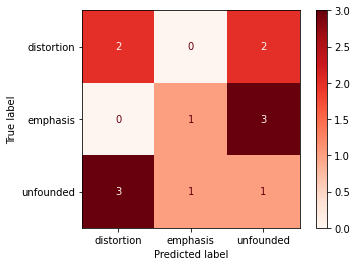

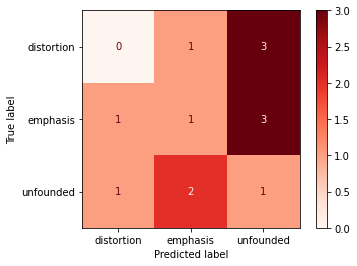

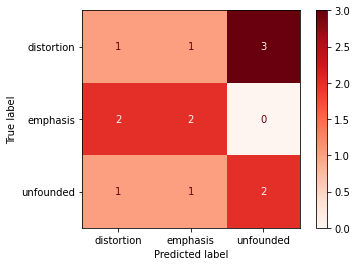

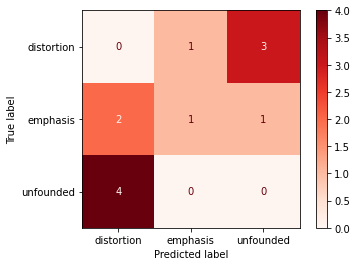

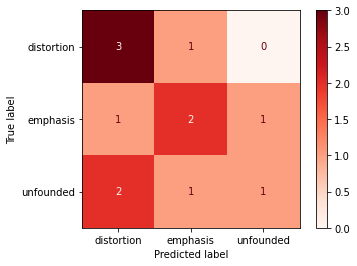

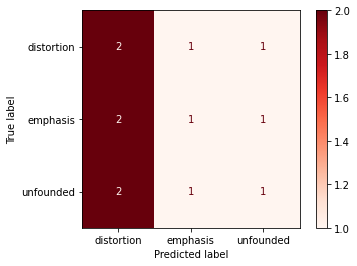

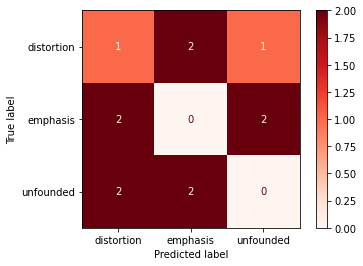

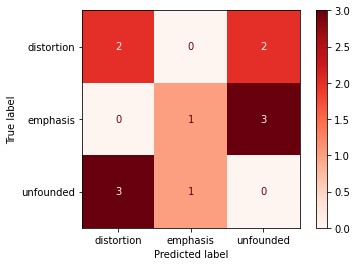

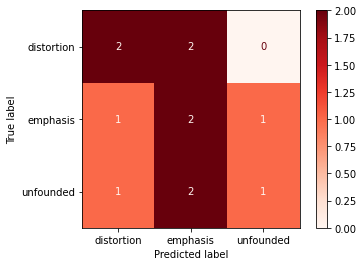

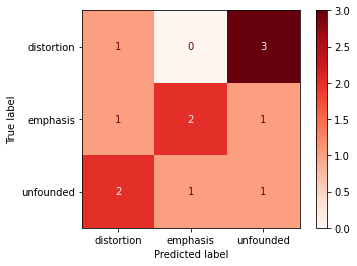

In [136]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest Evaluation
randForestClass = RandomForestClassifier()
parameters = {
              'criterion':('gini', 'entropy'), 
              'max_features':('auto', 'sqrt', 'log2'),
              'n_estimators':[100, 1000, 1500, 2000, 2500, 3000, 4000, 5000]
#               ,'max_depth': range(1,10)
             }
randForestClassifier = GridSearchCV(randForestClass, parameters, n_jobs = -1, cv=5, scoring='f1_macro')

bestModel, bestAccuracyTest, bestAccuracyVal, bestParams = HyperParameterTuningTfIdf(attentionData, randForestClassifier)

# Random Forest Classification Method Tf-Idf
print("\n---- Tf-Idf Results----\n")
# randForestClas = RandomForestClassifier(n_estimators=1000, random_state=0)
accuracyArrayX, meanF1Score, meanAccuracyX = TenFoldValidation_TfIdf(attentionData, bestModel)
print("Mean Accuracy: ", meanAccuracyX, " MeanF1Score: ",meanF1Score)

Fold  1  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.3265079365079365
Fold  2  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.40775132275132275
Fold  3  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.3415416065416065
Fold  4  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3484656084656085
Fold  5  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.31103174603174605
Fold  6  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3979100529100529
Fold  7  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.4447883597883598
Fold  8  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3775300625300625
Fold  9  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3511904761904762
Fold  10  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.31320105820105815

---- Word2Vec Results----

Iteration: 1  Accuracy Score:  0.46153846153846156
Iteration: 1  F1Macro  Score:  0.4433862433862434
-------------------------------------
Iteration: 2  Accuracy Score:  0.38461538461538464
Iteratio

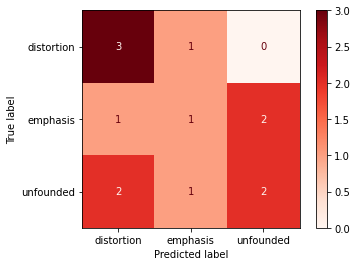

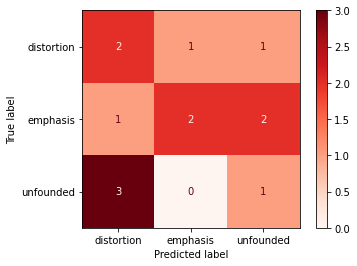

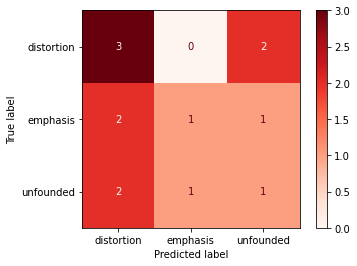

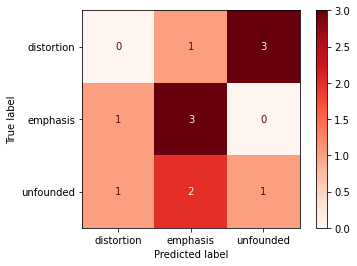

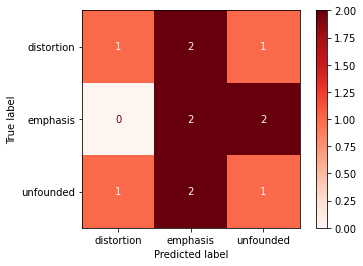

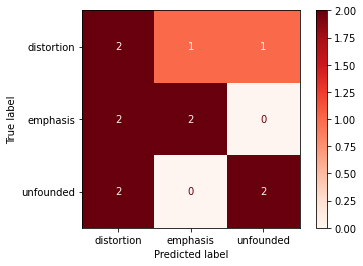

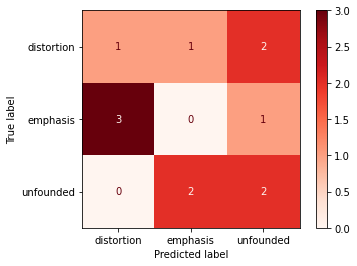

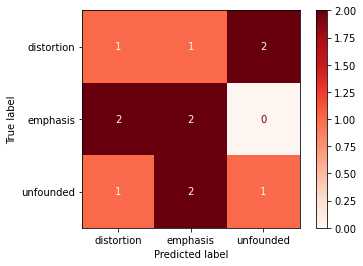

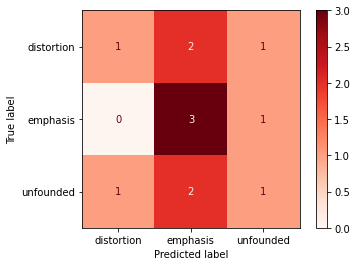

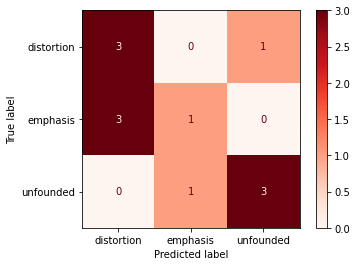

In [135]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest Evaluation
randForestClass = RandomForestClassifier()
parameters = {
              'criterion':('gini', 'entropy'), 
              'max_features':('auto', 'sqrt', 'log2'),
              'n_estimators':[100, 1000, 1500, 2000, 2500, 3000, 4000, 5000]
             }
randForestClassifier = GridSearchCV(randForestClass, parameters, n_jobs = -1, cv=10, scoring='f1_macro')

bestModel, bestAccuracyTest, bestAccuracyVal, bestParams = HyperParameterTuningWord2Vec(attentionData, randForestClassifier)

# Random Forest Classification Method

# Word2Vec
print("\n---- Word2Vec Results----\n")
accuracyArrayX, meanF1Score, meanAccuracyX = TenFoldValidation_Word2Vec(attentionData, bestModel)
print("Mean Accuracy: ", meanAccuracyY, " MeanF1Score",meanF1Score)

Fold  1  of tuning. F1Val:  0.38461538461538464  F1Kfold:  0.42333333333333334
Fold  2  of tuning. F1Val:  0.23076923076923078  F1Kfold:  0.39333333333333337
Fold  3  of tuning. F1Val:  0.0  F1Kfold:  0.42444444444444446
Fold  4  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.44222222222222224
Fold  5  of tuning. F1Val:  0.5  F1Kfold:  0.3944444444444445
Fold  6  of tuning. F1Val:  0.5  F1Kfold:  0.38222222222222224
Fold  7  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.4444444444444445
Fold  8  of tuning. F1Val:  0.16666666666666666  F1Kfold:  0.40444444444444444
Fold  9  of tuning. F1Val:  0.25  F1Kfold:  0.4133333333333334
Fold  10  of tuning. F1Val:  0.4166666666666667  F1Kfold:  0.3944444444444445

---- Tf-Idf Results----

Iteration: 1  Accuracy Score:  0.23
Iteration: 1  MacroF1 Score:  0.26
-------------------------------------
Iteration: 2  Accuracy Score:  0.38
Iteration: 2  MacroF1 Score:  0.4
-------------------------------------
Iteration: 3  Accuracy Score:  0.31


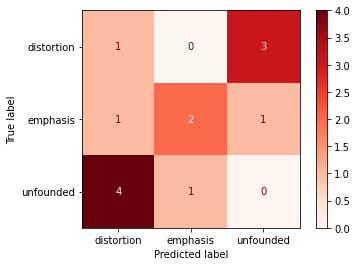

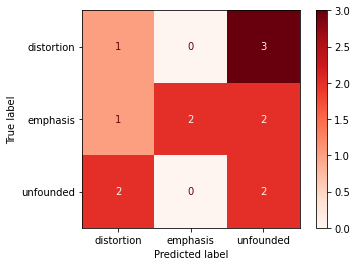

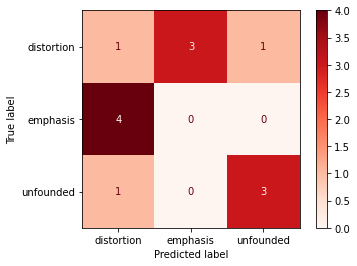

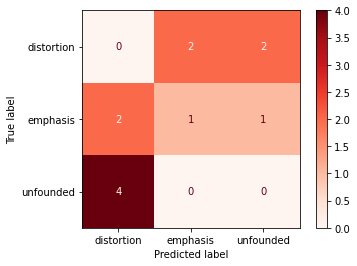

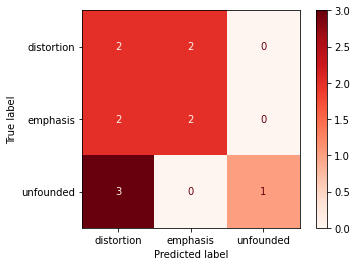

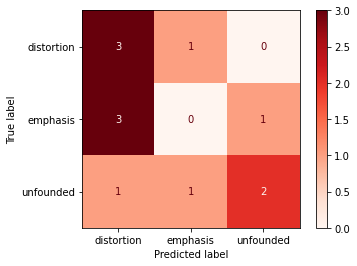

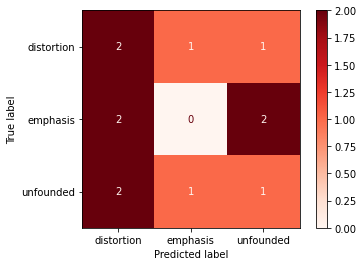

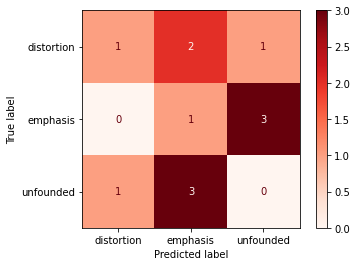

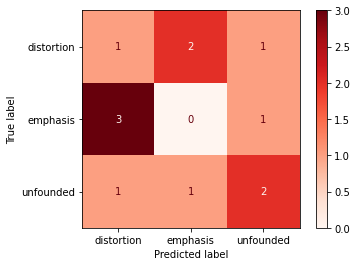

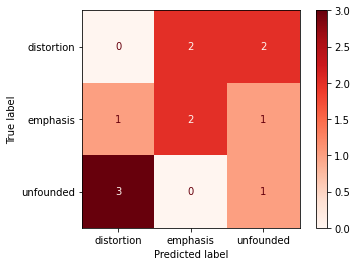

In [138]:
from sklearn.neighbors import KNeighborsClassifier

# # K-Neighbors Evaluation
kNeighborsClas = KNeighborsClassifier()
parameters = {
              'weights':('uniform', 'distance'), 
              'algorithm':('auto', 'ball_tree', 'kd_tree', 'brute'),
              'n_neighbors':range(1,150)
             }
kNClassifier = GridSearchCV(kNeighborsClas, parameters, n_jobs=-1, cv=10, scoring='accuracy')

bestModel, bestAccuracyTest, bestAccuracyVal, bestParams = HyperParameterTuningTfIdf(attentionData, kNClassifier)

# K-Neighbors Classifier Tf-Idf
print("\n---- Tf-Idf Results----\n")
accuracyArrayX, meanMacroF1, meanAccuracyX = TenFoldValidation_TfIdf(attentionData, bestModel)
print("Mean Accuracy: ", meanAccuracyX, " Mean F1Score: ", meanMacroF1)
print("Best Parameters for KNeighbours are: ",bestParams)

Fold  1  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.4142105263157895
Fold  2  of tuning. F1Val:  0.23076923076923078  F1Kfold:  0.4542105263157895
Fold  3  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.40368421052631576
Fold  4  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.4447368421052632
Fold  5  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.40421052631578946
Fold  6  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.4242105263157894
Fold  7  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.4152631578947368
Fold  8  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3836842105263158
Fold  9  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.44526315789473686
Fold  10  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3931578947368421

---- Word2Vec Results----

Iteration: 1  Accuracy Score:  0.46153846153846156
Iteration: 1  F1Macro  Score:  0.4554334554334554
-------------------------------------
Iteration: 2  Accuracy Score:  0.46153846153846156
Iterati

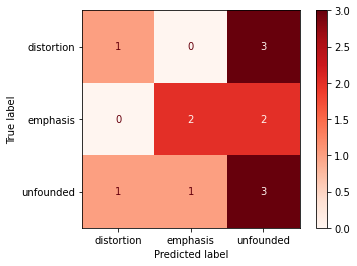

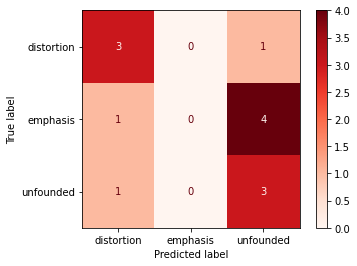

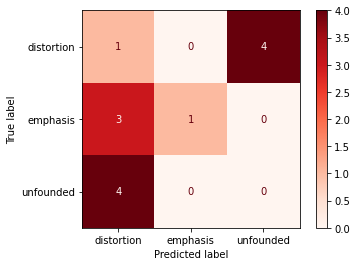

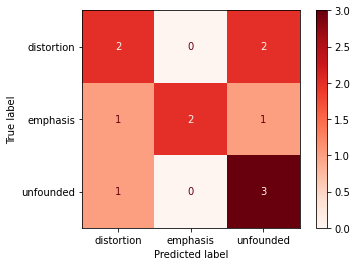

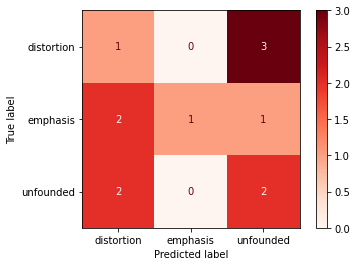

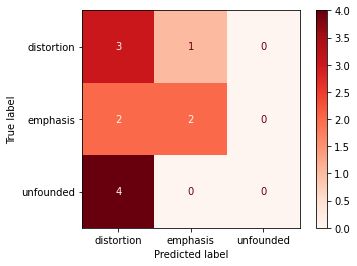

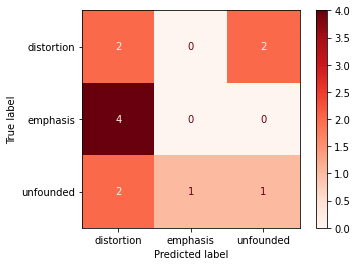

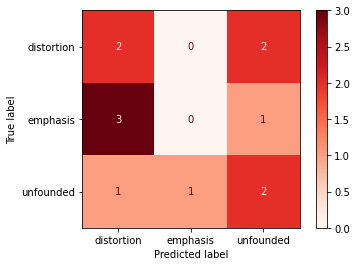

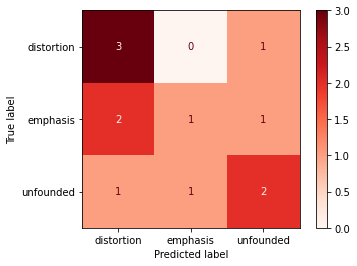

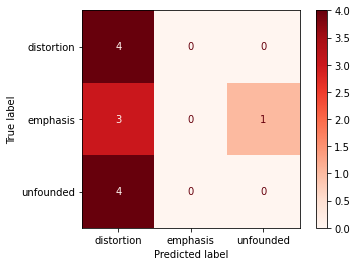

In [117]:
from sklearn.neighbors import KNeighborsClassifier

# K-Neighbors Evaluation
kNeighborsClas = KNeighborsClassifier()
parameters = {
              'weights':('uniform', 'distance'), 
              'algorithm':('auto', 'ball_tree', 'kd_tree', 'brute'),
              'n_neighbors':range(1,150)
             }
kNClassifier = GridSearchCV(kNeighborsClas, parameters, n_jobs=-1, cv=5, scoring='accuracy')

bestModel, bestAccuracyTest, bestAccuracyVal, bestParams = HyperParameterTuningWord2Vec(attentionData, kNClassifier)

# K-Neighbors Classifier

print("\n---- Word2Vec Results----\n")
# # Word2Vec
accuracyArrayY, meanF1Score, meanAccuracyY = TenFoldValidation_Word2Vec(attentionData, bestModel)
print("Mean Accuracy: ", meanAccuracyY, " MeanF1Score: ",meanF1Score)
print("Best parameters for KNeighbours are: ", bestParams)

Fold  1  of tuning. F1Val:  0.38461538461538464  F1Kfold:  0.3811111111111111
Fold  2  of tuning. F1Val:  0.15384615384615385  F1Kfold:  0.36111111111111116
Fold  3  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.39222222222222225
Fold  4  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.37666666666666665
Fold  5  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.32555555555555554
Fold  6  of tuning. F1Val:  0.5833333333333334  F1Kfold:  0.3244444444444444
Fold  7  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3644444444444444
Fold  8  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.37222222222222223
Fold  9  of tuning. F1Val:  0.25  F1Kfold:  0.37222222222222223
Fold  10  of tuning. F1Val:  0.4166666666666667  F1Kfold:  0.37444444444444447

---- Tf-Idf Results----

Iteration: 1  Accuracy Score:  0.46
Iteration: 1  MacroF1 Score:  0.38
-------------------------------------
Iteration: 2  Accuracy Score:  0.23
Iteration: 2  MacroF1 Score:  0.24
----------------------------

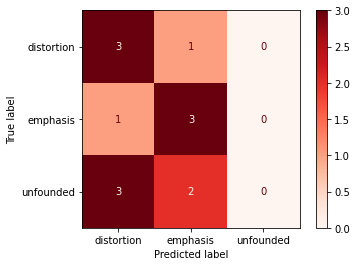

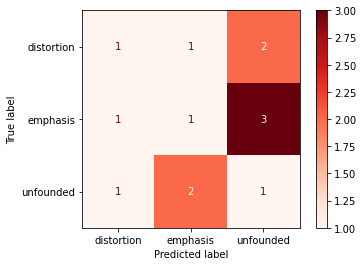

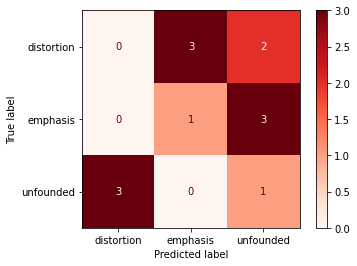

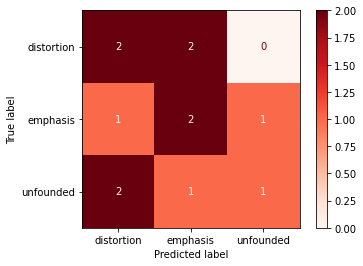

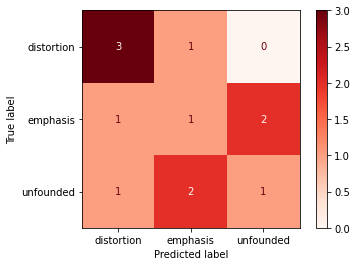

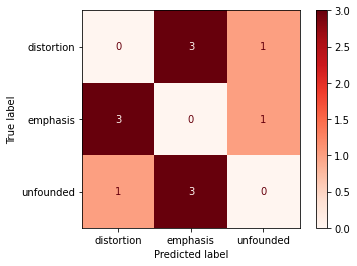

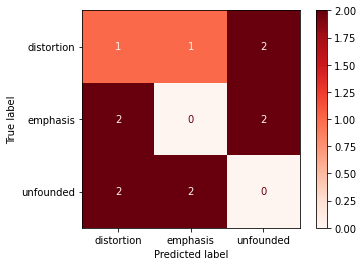

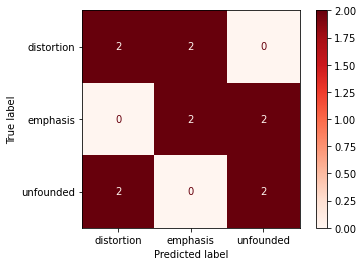

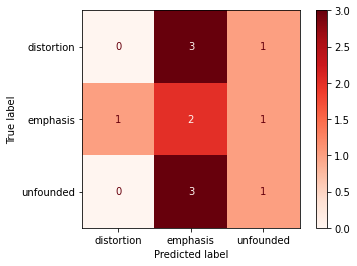

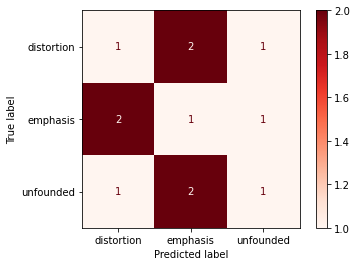

In [118]:
from sklearn.svm import SVC

# SVM Classifier Evaluation
svmClass = SVC()
parameters = {
                'kernel':('linear', 'rbf', 'poly', 'sigmoid'),
                'gamma': ('scale', 'auto'),
                'C': [0.01, 0.1, 1, 2, 10, 100]
             }
svmClassifier = GridSearchCV(svmClass, parameters, n_jobs = -1, cv=10, scoring='accuracy')

bestModel, bestAccuracyTest, bestAccuracyVal, bestParams = HyperParameterTuningTfIdf(attentionData, svmClassifier)

# SVM Classifier Tf-Idf
print("\n---- Tf-Idf Results----\n")
svmClas = SVC()
accuracyArrayX, meanMacroF1, meanAccuracyX = TenFoldValidation_TfIdf(attentionData, bestModel)
print("Mean Accuracy: ", meanAccuracyX, "Mean MacroF1: ", meanMacroF1)

Fold  1  of tuning. F1Val:  0.38461538461538464  F1Kfold:  0.36111111111111116
Fold  2  of tuning. F1Val:  0.38461538461538464  F1Kfold:  0.3844444444444444
Fold  3  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.33111111111111113
Fold  4  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3411111111111111
Fold  5  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.35444444444444445
Fold  6  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.41222222222222227
Fold  7  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.4144444444444444
Fold  8  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.40444444444444444
Fold  9  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.34444444444444444
Fold  10  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3433333333333333

---- Word2Vec Results----

Iteration: 1  Accuracy Score:  0.38461538461538464
Iteration: 1  F1Macro  Score:  0.3
-------------------------------------
Iteration: 2  Accuracy Score:  0.38461538461538464
Iteration: 2  F1Ma

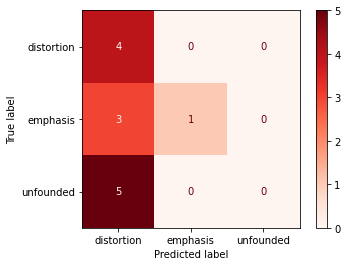

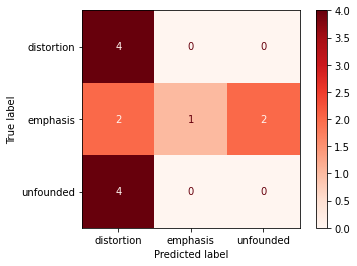

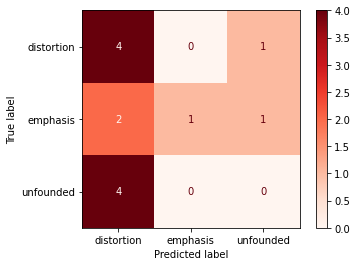

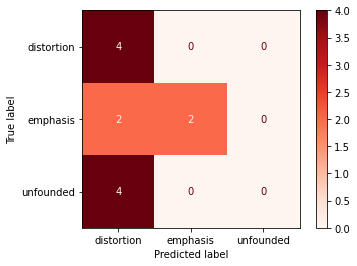

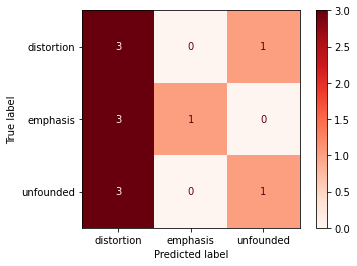

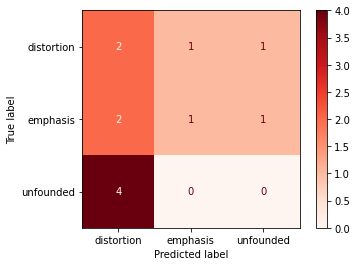

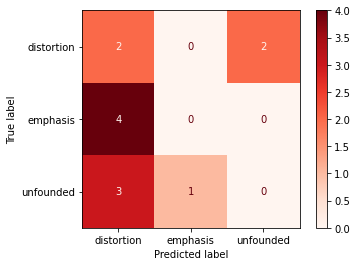

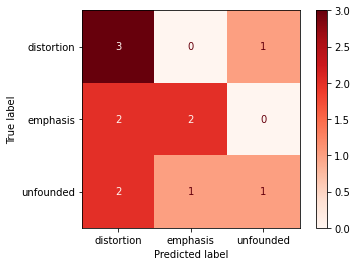

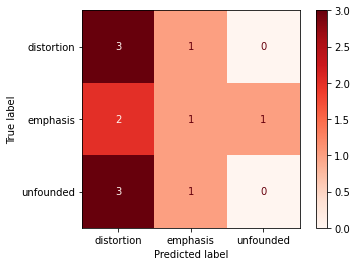

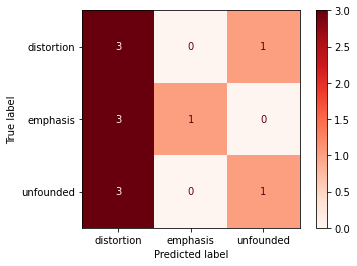

In [119]:
from sklearn.svm import SVC

# SVM Classifier Evaluation
svmClass = SVC()
parameters = {
                'kernel':('linear', 'rbf', 'poly', 'sigmoid'),
                'gamma': ('scale', 'auto'),
                'C': [0.01, 0.1, 1, 2, 10, 100]
             }
svmClassifier = GridSearchCV(svmClass, parameters, n_jobs = -1, cv=10, scoring='accuracy')

bestModel, bestAccuracyTest, bestAccuracyVal, bestParams = HyperParameterTuningWord2Vec(attentionData, svmClassifier)

# SVM Classifier

print("\n---- Word2Vec Results----\n")
# Word2Vec
accuracyArrayY, meanF1Score, meanAccuracyY = TenFoldValidation_Word2Vec(attentionData, bestModel)
print("Mean Accuracy: ", meanAccuracyY, " MeanF1Score: ",meanF1Score)

Fold  1  of tuning. F1Val:  0.46153846153846156  F1Kfold:  0.36897065897065906
Fold  2  of tuning. F1Val:  0.23076923076923078  F1Kfold:  0.2622486772486773
Fold  3  of tuning. F1Val:  0.5384615384615384  F1Kfold:  0.31066618566618565
Fold  4  of tuning. F1Val:  0.4166666666666667  F1Kfold:  0.3339153439153439
Fold  5  of tuning. F1Val:  0.25  F1Kfold:  0.23682539682539683
Fold  6  of tuning. F1Val:  0.4166666666666667  F1Kfold:  0.290983645983646
Fold  7  of tuning. F1Val:  0.5  F1Kfold:  0.292010582010582
Fold  8  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3021164021164021
Fold  9  of tuning. F1Val:  0.4166666666666667  F1Kfold:  0.2291798941798942
Fold  10  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.28674603174603175

---- Tf-Idf Results----

Iteration: 1  Accuracy Score:  0.54
Iteration: 1  MacroF1 Score:  0.55
-------------------------------------
Iteration: 2  Accuracy Score:  0.23
Iteration: 2  MacroF1 Score:  0.21
-------------------------------------
Iteration:

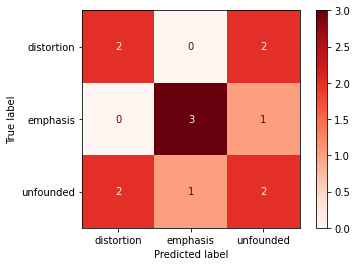

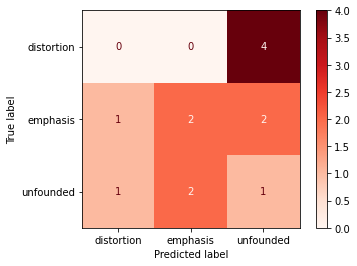

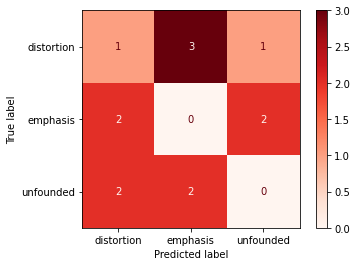

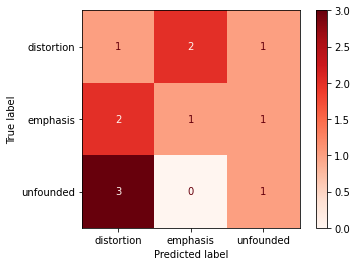

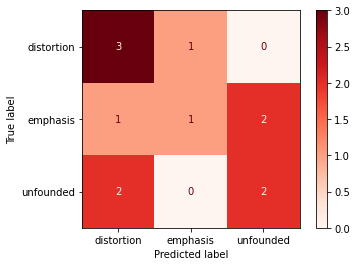

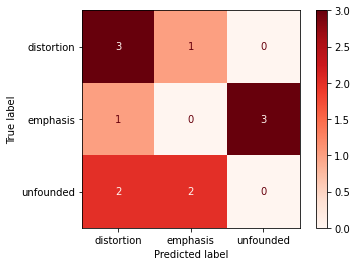

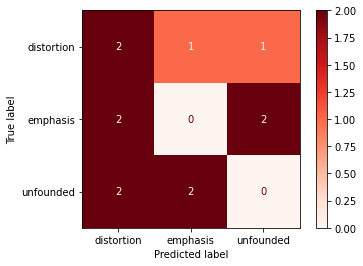

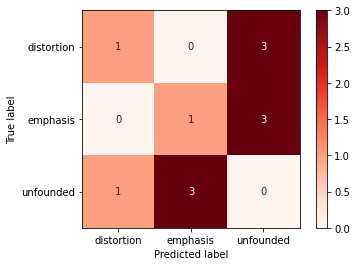

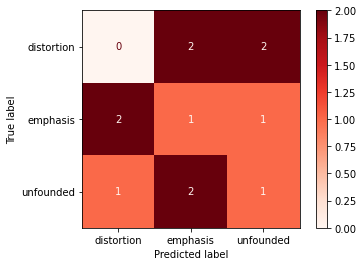

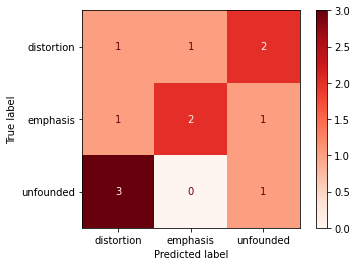

In [104]:
from sklearn.svm import LinearSVC

# Linear SVC Classifier Evaluation
linearSVC = LinearSVC()
parameters = {
                'loss': ('hinge', 'squared_hinge'),
                'multi_class': ('ovr', 'crammer_singer'),
                'C': [0.01, 0.1, 1.0, 2.0, 10.0, 100.0],
                'max_iter': [1000, 2000, 5000, 10000]
             }
linearSVCClassifier = GridSearchCV(linearSVC, parameters, n_jobs = -1, cv=10, scoring='accuracy')

bestModel, bestAccuracyTest, bestAccuracyVal, bestParams = HyperParameterTuningTfIdf(attentionData, linearSVCClassifier)

# SVM Classifier Tf-Idf
print("\n---- Tf-Idf Results----\n")
accuracyArrayX, meanMacroF1, meanAccuracyX = TenFoldValidation_TfIdf(attentionData, bestModel)
print("Mean Accuracy: ", meanAccuracyX, " MeanMacroF1: ", meanMacroF1)

Fold  1  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.3416984866984867
Fold  2  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.34383597883597883
Fold  3  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.3192977392977393
Fold  4  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3051106301106301
Fold  5  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3411640211640212
Fold  6  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3651058201058201
Fold  7  of tuning. F1Val:  0.4166666666666667  F1Kfold:  0.4129148629148629
Fold  8  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3435810485810486
Fold  9  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3506156806156806
Fold  10  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3446031746031747

---- Word2Vec Results----

Iteration: 1  Accuracy Score:  0.3076923076923077
Iteration: 1  F1Macro  Score:  0.24074074074074073
-------------------------------------
Iteration: 2  Accuracy Score:  0.3076923076923077
Iteration: 

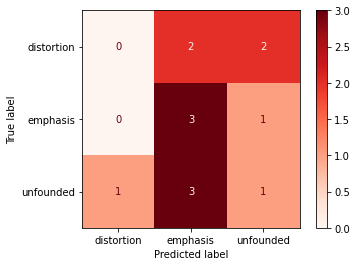

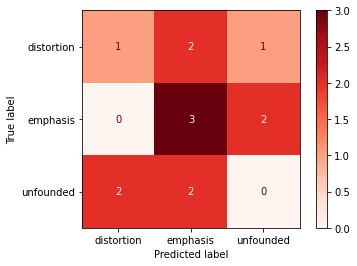

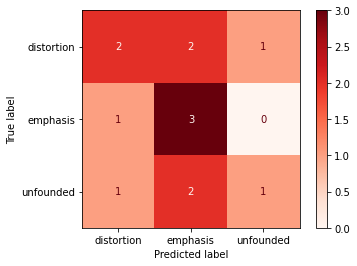

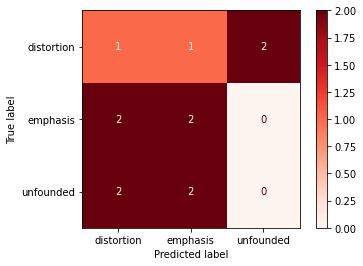

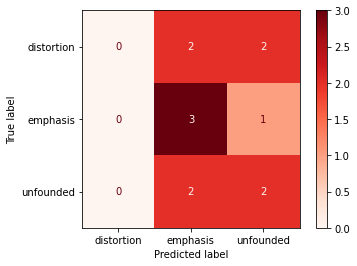

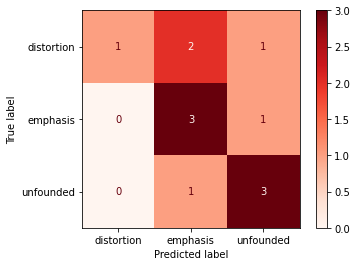

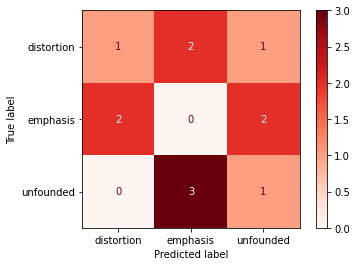

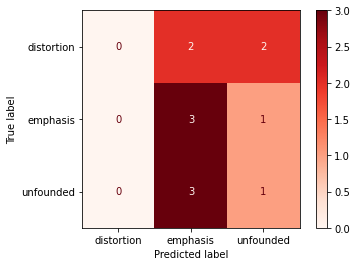

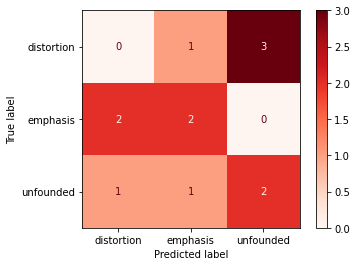

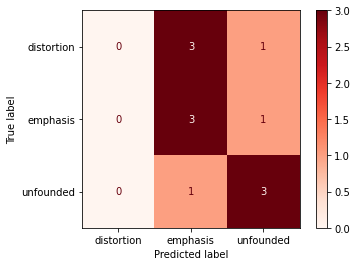

In [105]:
from sklearn.svm import LinearSVC

# Linear SVC Classifier Evaluation
linearSVC = LinearSVC()
parameters = {
                'loss': ('hinge', 'squared_hinge'),
                'multi_class': ('ovr', 'crammer_singer'),
                'C': [0.01, 0.1, 1.0, 2.0, 10.0, 100.0],
                'max_iter': [1000, 2000, 5000, 10000]
             }
linearSVCClassifier = GridSearchCV(linearSVC, parameters, n_jobs = -1, cv=10, scoring='f1_macro')

bestModel, bestAccuracyTest, bestAccuracyVal, bestParams = HyperParameterTuningWord2Vec(attentionData, linearSVCClassifier)

# SVM Classifier

print("\n---- Word2Vec Results----\n")
# Word2Vec
accuracyArrayY, meanF1Score, meanAccuracyY = TenFoldValidation_Word2Vec(attentionData, bestModel)
print("Mean Accuracy: ", meanAccuracyY, " MeanF1Score: ",meanF1Score)

Fold  1  of tuning. F1Val:  0.46153846153846156  F1Kfold:  0.35000000000000003
Fold  2  of tuning. F1Val:  0.23076923076923078  F1Kfold:  0.2577777777777778
Fold  3  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.3511111111111111
Fold  4  of tuning. F1Val:  0.4166666666666667  F1Kfold:  0.3055555555555555
Fold  5  of tuning. F1Val:  0.5833333333333334  F1Kfold:  0.25222222222222224
Fold  6  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.2733333333333334
Fold  7  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.33444444444444443
Fold  8  of tuning. F1Val:  0.4166666666666667  F1Kfold:  0.3411111111111111
Fold  9  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.24222222222222226
Fold  10  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3244444444444444

---- Tf-Idf Results----

Iteration: 1  Accuracy Score:  0.38
Iteration: 1  MacroF1 Score:  0.38
-------------------------------------
Iteration: 2  Accuracy Score:  0.31
Iteration: 2  MacroF1 Score:  0.3
------------------

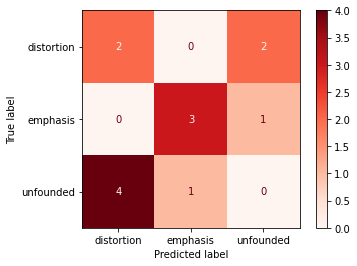

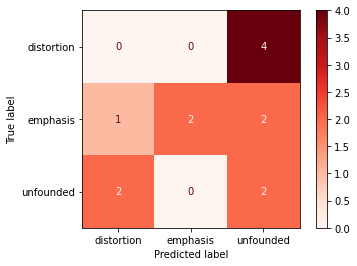

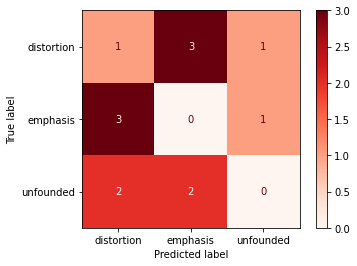

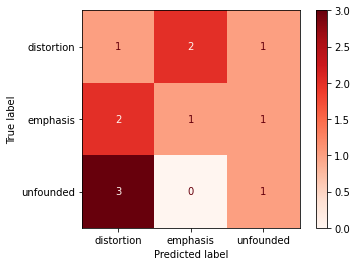

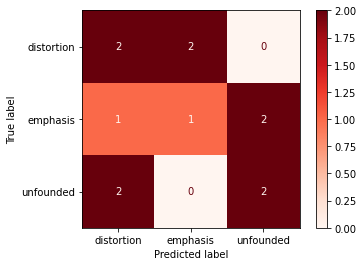

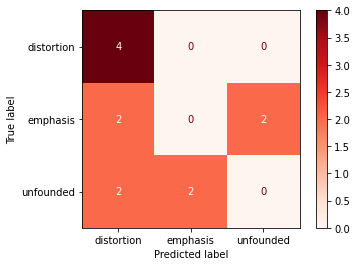

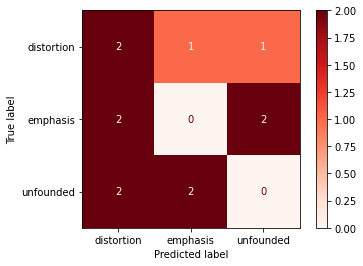

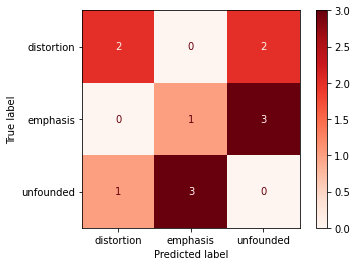

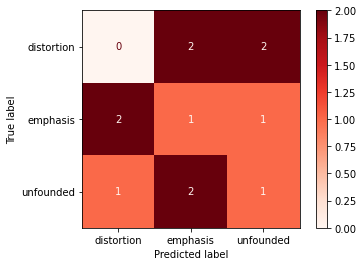

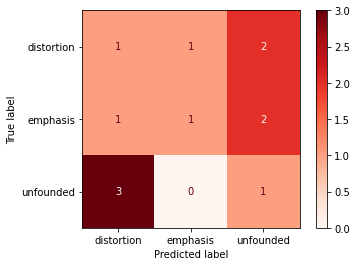

In [120]:
from sklearn.gaussian_process import GaussianProcessClassifier

# Gaussian Process Classifier Evaluation
gaussianProcClas = GaussianProcessClassifier()
parameters = {
                'multi_class': ('one_vs_rest', 'one_vs_one'),
                'max_iter_predict': [100, 200, 300, 400, 500]
             }
gaussianProcClassifier = GridSearchCV(gaussianProcClas, parameters, n_jobs = -1, cv=10, scoring='accuracy')

bestModel, bestAccuracyTest, bestAccuracyVal, bestParams = HyperParameterTuningTfIdf(attentionData, gaussianProcClassifier)

# Gaussian Process Classifier Tf-Idf
print("\n---- Tf-Idf Results----\n")
# gaussianProcClas = GaussianProcessClassifier()
accuracyArrayX, meanMacroF1, meanAccuracyX = TenFoldValidation_TfIdf(attentionData, bestModel)
print("Mean Accuracy: ", meanAccuracyX, " MeanMacroF1: ", meanMacroF1)

Fold  1  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.33
Fold  2  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.32
Fold  3  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.37
Fold  4  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3844444444444444
Fold  5  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3366666666666666
Fold  6  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.36444444444444446
Fold  7  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3855555555555556
Fold  8  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.37444444444444447
Fold  9  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3155555555555556
Fold  10  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.30333333333333334

---- Word2Vec Results----

Iteration: 1  Accuracy Score:  0.46153846153846156
Iteration: 1  F1Macro  Score:  0.38888888888888884
-------------------------------------
Iteration: 2  Accuracy Score:  0.38461538461538464
Iteration: 2  F1Macro  Score:  0.2857142857142857

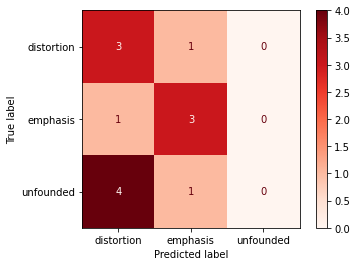

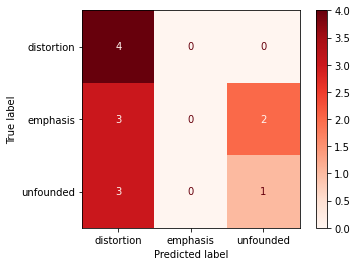

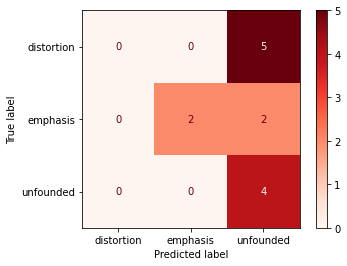

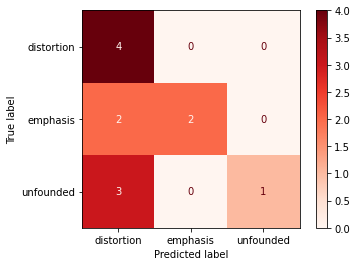

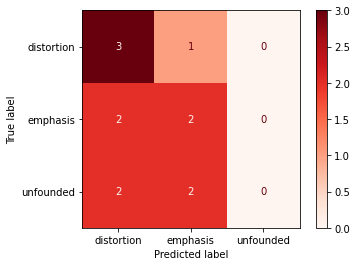

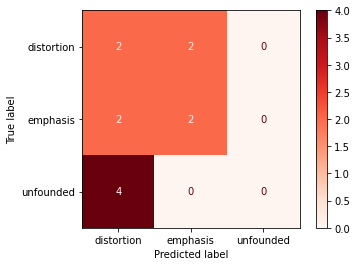

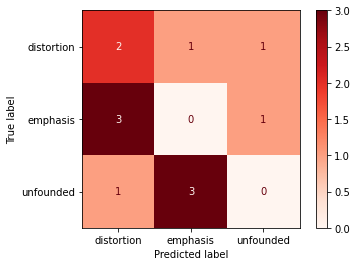

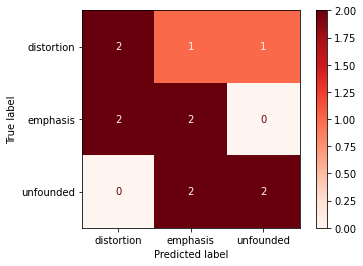

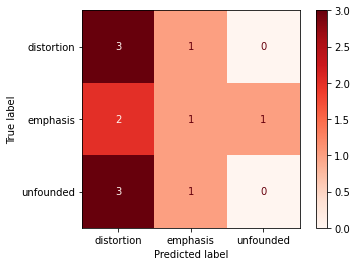

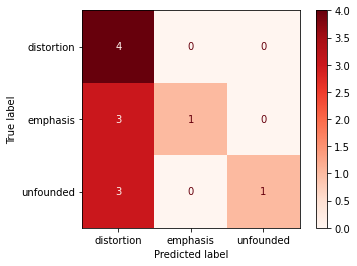

In [121]:
from sklearn.gaussian_process import GaussianProcessClassifier

# Gaussian Process Classifier Evaluation
gaussianProcClas = GaussianProcessClassifier()
parameters = {
                'multi_class': ('one_vs_rest', 'one_vs_one'),
                'max_iter_predict': [100, 200, 300, 400, 500]
             }
gaussianProcClassifier = GridSearchCV(gaussianProcClas, parameters, n_jobs = -1, cv=10, scoring='accuracy')

bestModel, bestAccuracyTest, bestAccuracyVal, bestParams = HyperParameterTuningWord2Vec(attentionData, gaussianProcClassifier)

# Gaussian Process Classifier

print("\n---- Word2Vec Results----\n")
# Word2Vec
# gaussianProcClas = GaussianProcessClassifier()
accuracyArrayY, meanF1Score, meanAccuracyY = TenFoldValidation_Word2Vec(attentionData, bestModel)
print("Mean Accuracy: ", meanAccuracyY, "MeanF1Score: ",meanF1Score)

Fold  1  of tuning. F1Val:  0.5384615384615384  F1Kfold:  0.4144444444444445
Fold  2  of tuning. F1Val:  0.38461538461538464  F1Kfold:  0.41111111111111115
Fold  3  of tuning. F1Val:  0.23076923076923078  F1Kfold:  0.39222222222222225
Fold  4  of tuning. F1Val:  0.16666666666666666  F1Kfold:  0.3422222222222222
Fold  5  of tuning. F1Val:  0.5  F1Kfold:  0.4033333333333333
Fold  6  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3611111111111111
Fold  7  of tuning. F1Val:  0.4166666666666667  F1Kfold:  0.42444444444444446
Fold  8  of tuning. F1Val:  0.4166666666666667  F1Kfold:  0.39111111111111113
Fold  9  of tuning. F1Val:  0.4166666666666667  F1Kfold:  0.38333333333333336
Fold  10  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.37555555555555553

---- Bow - Tf-Idf Results----

Iteration: 1  Accuracy Score:  0.31
Iteration: 1  MacroF1 Score:  0.28
-------------------------------------
Iteration: 2  Accuracy Score:  0.46
Iteration: 2  MacroF1 Score:  0.45
-----------------------

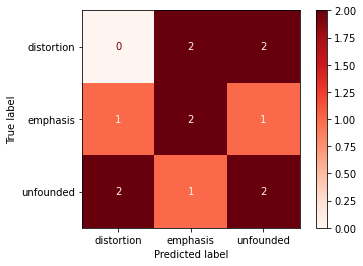

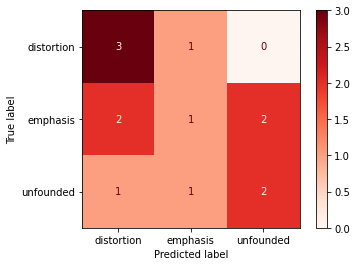

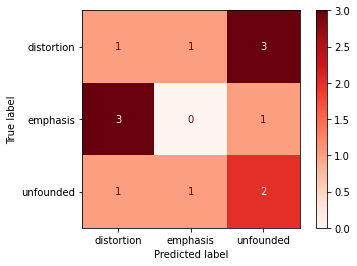

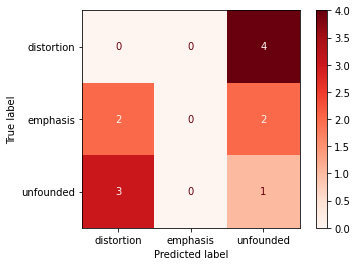

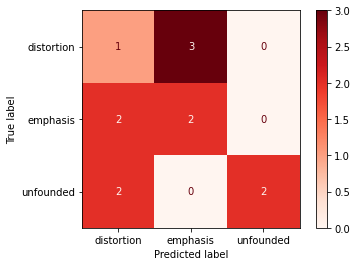

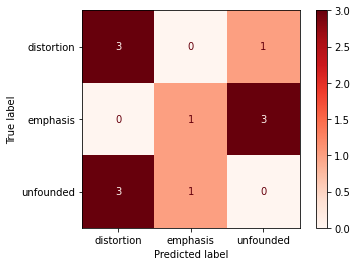

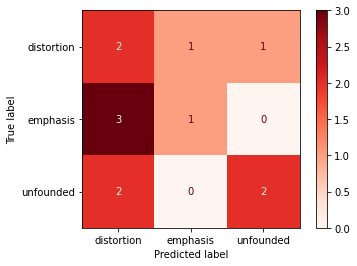

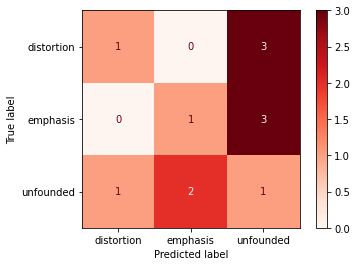

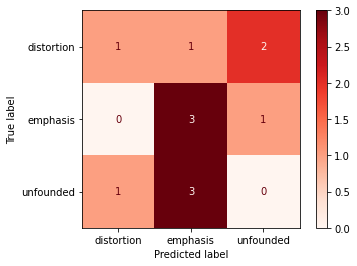

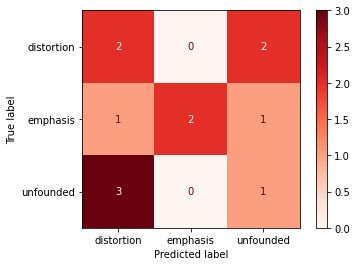

In [122]:
from sklearn.tree import DecisionTreeClassifier

# Decision Tree Classifier Evaluation

decisionTreeClas = DecisionTreeClassifier()
parameters = {
                'criterion': ('gini', 'entropy'),
                'splitter': ('best', 'random'),
                'max_features':  ('auto', 'sqrt', 'log2', 'None')
             }
decisionTreeClassifier = GridSearchCV(decisionTreeClas, parameters, n_jobs = -1, cv=10, scoring='accuracy')

bestModel, bestAccuracyTest, bestAccuracyVal, bestParams = HyperParameterTuningTfIdf(attentionData, decisionTreeClassifier)

# Decision Tree Classifier

# Bow - Tf-Idf
print("\n---- Bow - Tf-Idf Results----\n")
decisionTreeClas = DecisionTreeClassifier()
accuracyArrayX, meanF1Score, meanAccuracyX = TenFoldValidation_TfIdf(attentionData, bestModel)
print("Mean Accuracy: ", meanAccuracyX, " Mean MacroF1Score: ",meanF1Score)

Fold  1  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.4455555555555555
Fold  2  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.38777777777777783
Fold  3  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.4288888888888889
Fold  4  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.4133333333333334
Fold  5  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.42333333333333334
Fold  6  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.4144444444444445
Fold  7  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.40444444444444444
Fold  8  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.42444444444444446
Fold  9  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.4955555555555556
Fold  10  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.39333333333333337

---- Word2Vec Results----

Iteration: 1  Accuracy Score:  0.46153846153846156
Iteration: 1  F1Macro  Score:  0.4444444444444445
-------------------------------------
Iteration: 2  Accuracy Score:  0.5384615384615384
Iterati

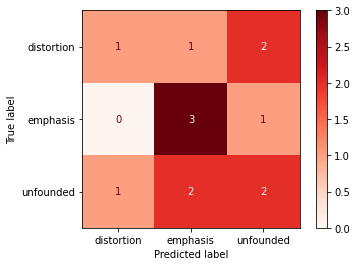

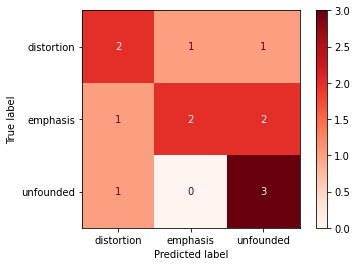

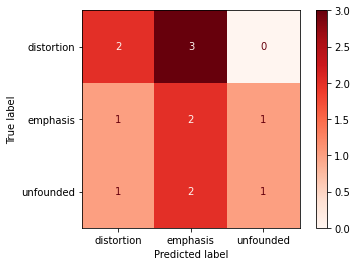

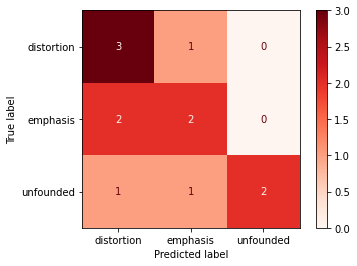

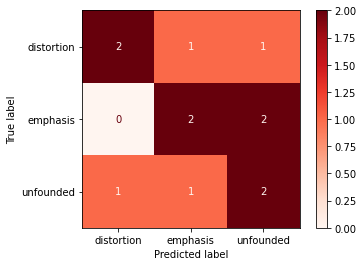

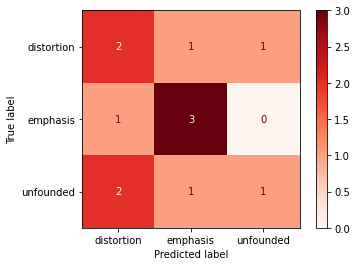

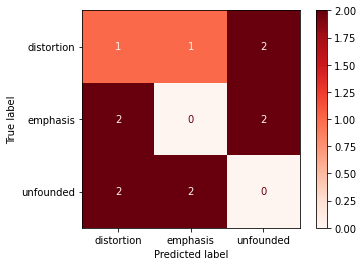

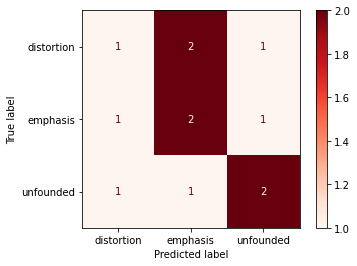

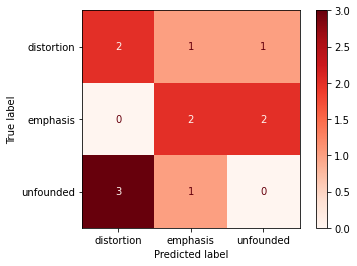

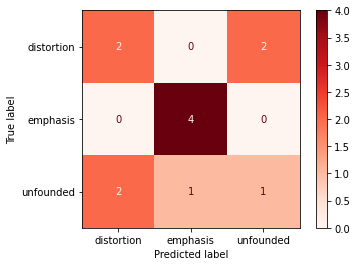

In [123]:
from sklearn.tree import DecisionTreeClassifier

# Decision Tree Classifier Evaluation

decisionTreeClas = DecisionTreeClassifier()
parameters = {
                'criterion': ('gini', 'entropy'),
                'splitter': ('best', 'random'),
                'max_features':  ('auto', 'sqrt', 'log2', 'None')
             }
decisionTreeClassifier = GridSearchCV(decisionTreeClas, parameters, n_jobs = -1, cv=10, scoring='accuracy')

bestModel, bestAccuracyTest, bestAccuracyVal, bestParams = HyperParameterTuningWord2Vec(attentionData, decisionTreeClassifier)

# Decision Tree Classifier

print("\n---- Word2Vec Results----\n")
# Word2Vec
accuracyArrayY, meanF1Score, meanAccuracyY = TenFoldValidation_Word2Vec(attentionData, bestModel)
print("Mean Accuracy: ", meanAccuracyY, "MeanF1Score: ",meanF1Score)

Fold  1  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.39111111111111113
Fold  2  of tuning. F1Val:  0.38461538461538464  F1Kfold:  0.3388888888888889
Fold  3  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.35333333333333333
Fold  4  of tuning. F1Val:  0.25  F1Kfold:  0.37444444444444447
Fold  5  of tuning. F1Val:  0.5833333333333334  F1Kfold:  0.31222222222222223
Fold  6  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.32222222222222224
Fold  7  of tuning. F1Val:  0.5  F1Kfold:  0.3411111111111111
Fold  8  of tuning. F1Val:  0.5833333333333334  F1Kfold:  0.33111111111111113
Fold  9  of tuning. F1Val:  0.25  F1Kfold:  0.3944444444444445
Fold  10  of tuning. F1Val:  0.25  F1Kfold:  0.3433333333333333

---- Tf-Idf Results----

Iteration: 1  Accuracy Score:  0.69
Iteration: 1  MacroF1 Score:  0.69
-------------------------------------
Iteration: 2  Accuracy Score:  0.38
Iteration: 2  MacroF1 Score:  0.32
-------------------------------------
Iteration: 3  Accuracy Score:  0.31

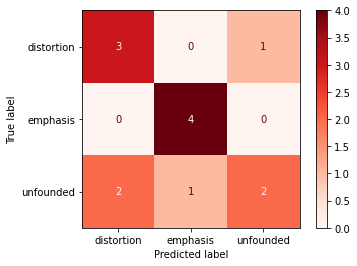

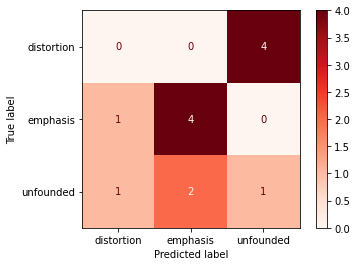

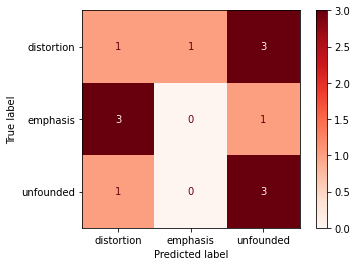

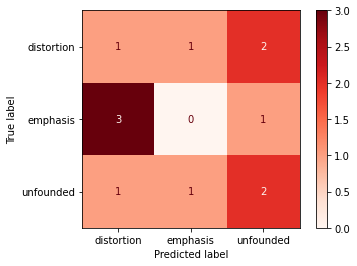

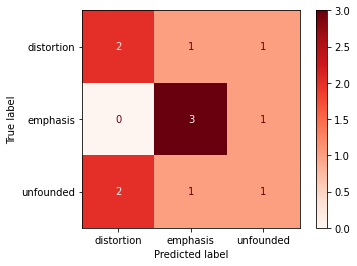

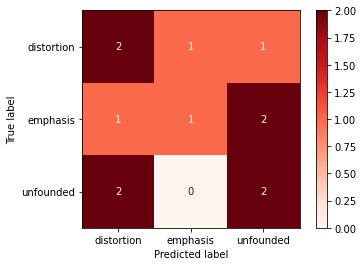

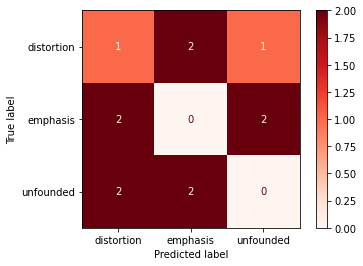

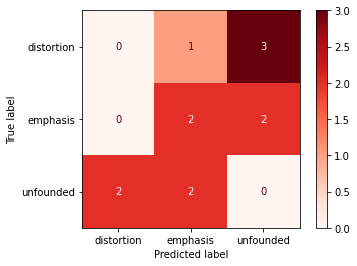

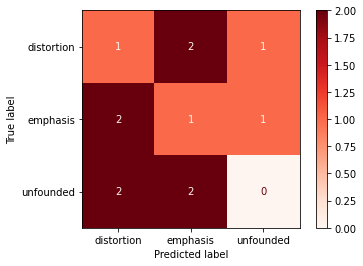

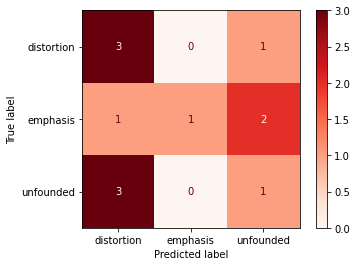

In [124]:
from sklearn.ensemble import AdaBoostClassifier

# Ada Boost Classifier Evaluation

adaBoostClas = AdaBoostClassifier()
parameters = {
                'n_estimators':  [10, 50, 100, 150, 200, 250, 300]
             }
adaBoostClassifier = GridSearchCV(adaBoostClas, parameters, n_jobs = -1, cv=10, scoring='accuracy')

bestModel, bestAccuracyTest, bestAccuracyVal, bestParams = HyperParameterTuningTfIdf(attentionData, adaBoostClassifier)

# Ada Boost Classifier Tf-Idf
print("\n---- Tf-Idf Results----\n")
adaBoostClas = AdaBoostClassifier()
accuracyArrayX, meanF1Score, meanAccuracyX = TenFoldValidation_TfIdf(attentionData, bestModel)
print("Mean Accuracy: ", meanAccuracyX, " Mean MacroF1Score: ",meanF1Score)

Fold  1  of tuning. F1Val:  0.38461538461538464  F1Kfold:  0.3821052631578947
Fold  2  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.3626315789473684
Fold  3  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.4131578947368421
Fold  4  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.33315789473684215
Fold  5  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3626315789473684
Fold  6  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.2736842105263158
Fold  7  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.35473684210526313
Fold  8  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3026315789473684
Fold  9  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.4742105263157894
Fold  10  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3942105263157895

---- Word2Vec Results----

Iteration: 1  Accuracy Score:  0.3076923076923077
Iteration: 1  F1Macro  Score:  0.30264550264550266
-------------------------------------
Iteration: 2  Accuracy Score:  0.23076923076923078
Iteratio

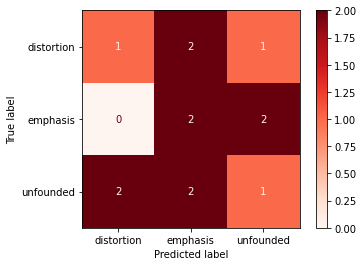

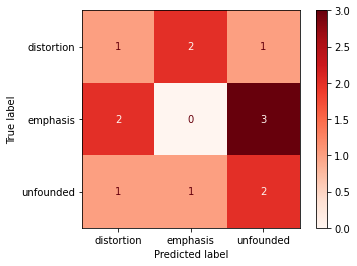

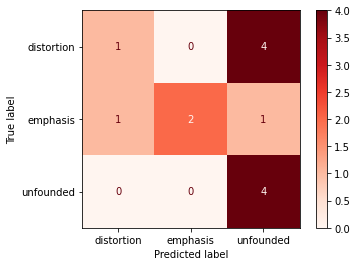

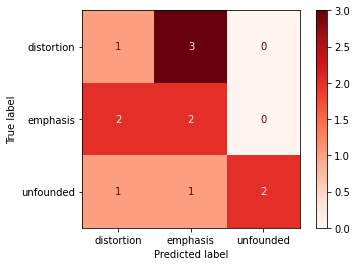

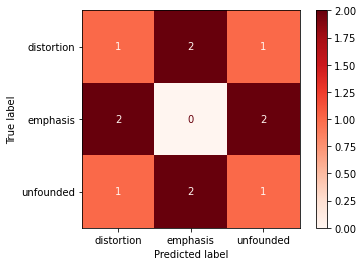

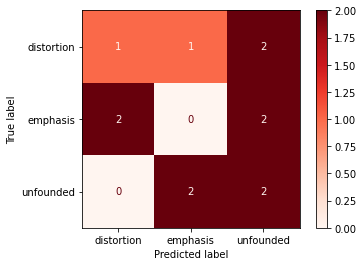

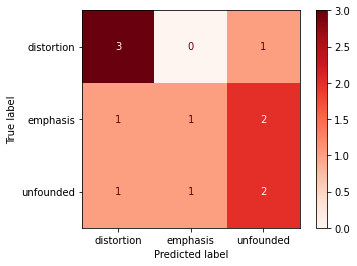

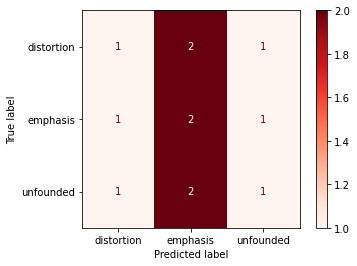

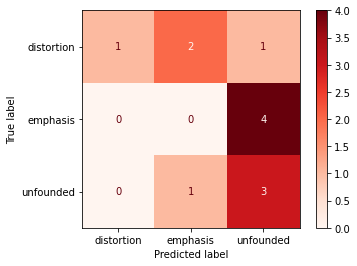

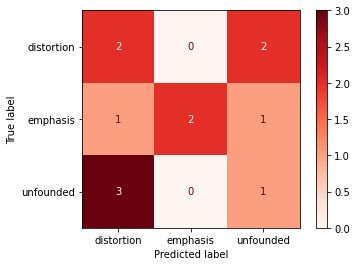

In [125]:
from sklearn.ensemble import AdaBoostClassifier

# Ada Boost Classifier Evaluation

adaBoostClas = AdaBoostClassifier()
parameters = {
                'n_estimators':  [50, 100, 150, 200]
             }
adaBoostClassifier = GridSearchCV(adaBoostClas, parameters, n_jobs = -1, cv=5, scoring='accuracy')

bestModel, bestAccuracyTest, bestAccuracyVal, bestParams = HyperParameterTuningWord2Vec(attentionData, adaBoostClassifier)

# Ada Boost Classifier

print("\n---- Word2Vec Results----\n")
# Word2Vec
accuracyArrayY, meanF1Score, meanAccuracyY = TenFoldValidation_Word2Vec(attentionData, bestModel)
print("Mean Accuracy: ", meanAccuracyY, " MeanF1Score: ", meanF1Score)

Fold  1  of tuning. F1Val:  0.46153846153846156  F1Kfold:  0.4133333333333334
Fold  2  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.2677777777777778
Fold  3  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.3288888888888889
Fold  4  of tuning. F1Val:  0.4166666666666667  F1Kfold:  0.31333333333333335
Fold  5  of tuning. F1Val:  0.4166666666666667  F1Kfold:  0.2111111111111111
Fold  6  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.27222222222222225
Fold  7  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.32222222222222224
Fold  8  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3211111111111111
Fold  9  of tuning. F1Val:  0.4166666666666667  F1Kfold:  0.23222222222222225
Fold  10  of tuning. F1Val:  0.4166666666666667  F1Kfold:  0.31333333333333335

---- Tf-Idf Results----

Iteration: 1  Accuracy Score:  0.46
Iteration: 1  MacroF1 Score:  0.47
-------------------------------------
Iteration: 2  Accuracy Score:  0.31
Iteration: 2  MacroF1 Score:  0.3
------------------

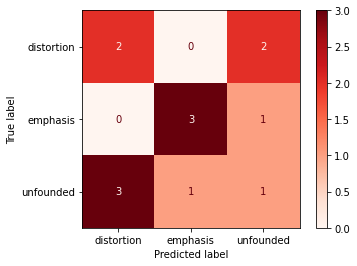

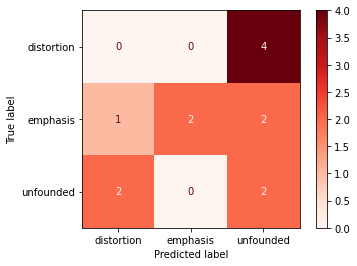

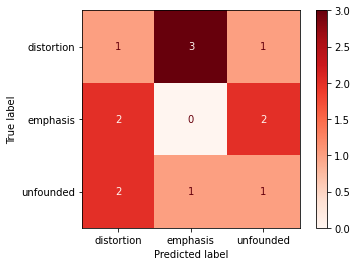

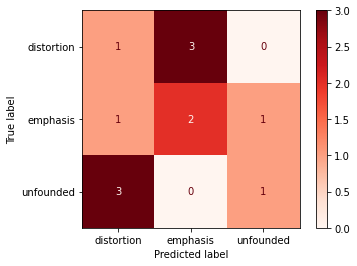

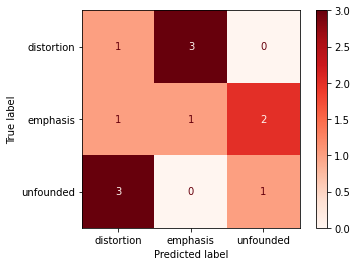

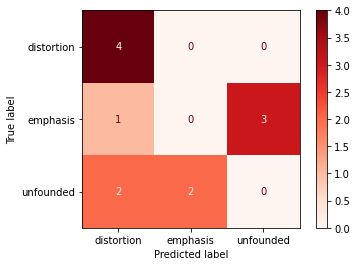

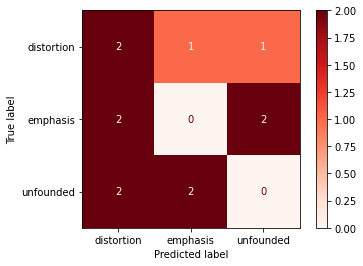

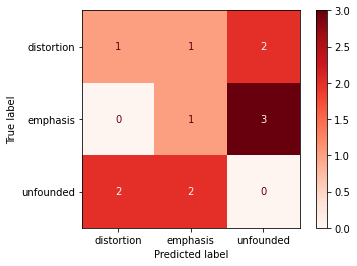

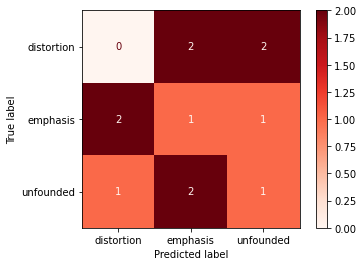

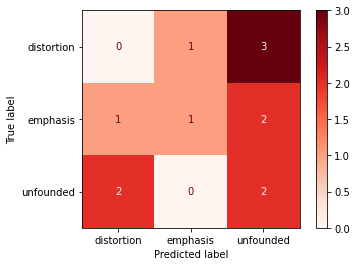

In [126]:
from sklearn.naive_bayes import MultinomialNB

# Multinomial Naive Bayes Classifier
multiNBClas = MultinomialNB()
parameters = {
                'alpha': [1, 0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
             }
multiNBClassifier = GridSearchCV(multiNBClas, parameters, n_jobs = -1, cv=10, scoring='accuracy')

bestModel, bestAccuracyTest, bestAccuracyVal, bestParams = HyperParameterTuningTfIdf(attentionData, multiNBClassifier)

# MultinomialNB Tf-Idf
print("\n---- Tf-Idf Results----\n")
accuracyArrayX, meanF1Score, meanAccuracyX = TenFoldValidation_TfIdf(attentionData, bestModel)
print("Mean Accuracy: ", meanAccuracyX, " MeanMacroF1Score: ", meanF1Score)

Fold  1  of tuning. F1Val:  0.46153846153846156  F1Kfold:  0.4025998075998077
Fold  2  of tuning. F1Val:  0.23076923076923078  F1Kfold:  0.343030118030118
Fold  3  of tuning. F1Val:  0.38461538461538464  F1Kfold:  0.37862433862433864
Fold  4  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.353015873015873
Fold  5  of tuning. F1Val:  0.25  F1Kfold:  0.3549013949013949
Fold  6  of tuning. F1Val:  0.4166666666666667  F1Kfold:  0.3363184963184963
Fold  7  of tuning. F1Val:  0.4166666666666667  F1Kfold:  0.35565175565175566
Fold  8  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.35924482924482926
Fold  9  of tuning. F1Val:  0.25  F1Kfold:  0.3307022607022606
Fold  10  of tuning. F1Val:  0.4166666666666667  F1Kfold:  0.33126984126984127

---- Tf-Idf Results----

Iteration: 1  Accuracy Score:  0.46
Iteration: 1  MacroF1 Score:  0.46
-------------------------------------
Iteration: 2  Accuracy Score:  0.08
Iteration: 2  MacroF1 Score:  0.07
-------------------------------------
Iteratio

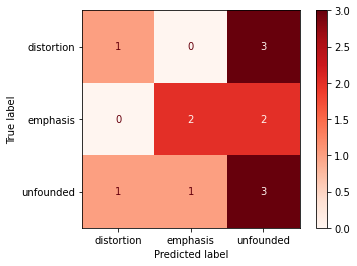

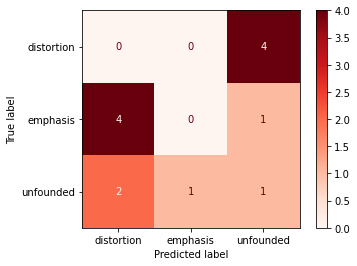

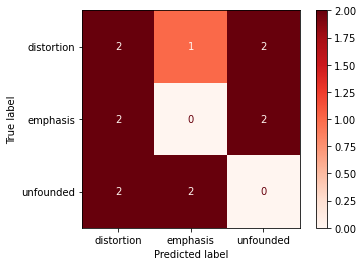

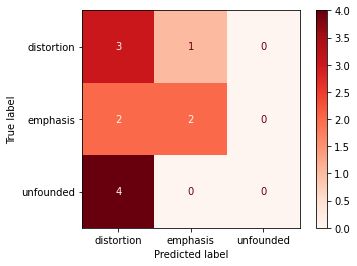

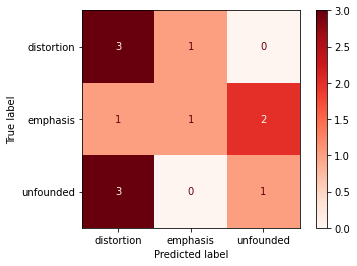

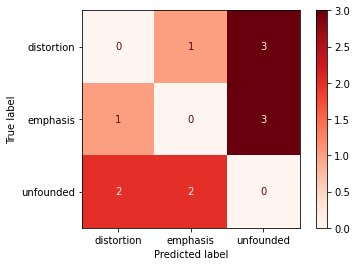

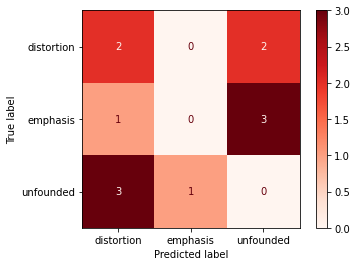

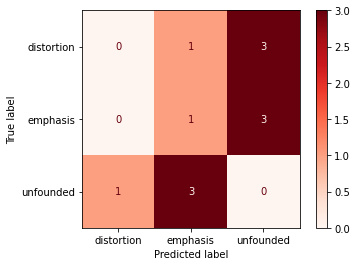

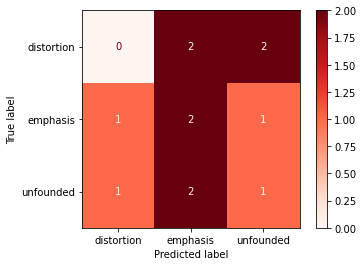

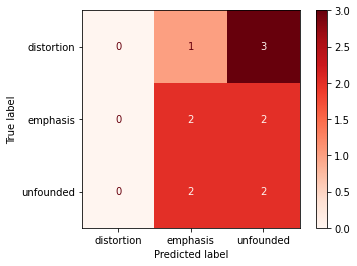

In [115]:
from sklearn.linear_model import SGDClassifier

# SGD Classifier

sgdClas = SGDClassifier()
parameters = {
                'penalty': ('l2', 'l1', 'elasticnet'),
                'alpha': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
                'max_iter' : [500, 1000, 10000],
                'tol': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
                'n_iter_no_change': [5, 10, 15, 20],
                'early_stopping': (True, False)
             }
sgdClassifier = GridSearchCV(sgdClas, parameters, n_jobs = -1, cv=10, scoring='f1_macro')

bestModel, bestAccuracyTest, bestAccuracyVal, bestParams = HyperParameterTuningTfIdf(attentionData, sgdClassifier)

# SGDClassifier Tf-Idf
print("\n---- Tf-Idf Results----\n")
accuracyArrayX, meanF1Score, meanAccuracyX = TenFoldValidation_TfIdf(attentionData, bestModel)
print("Mean Accuracy: ", meanAccuracyX, " MeanF1Score: ", meanF1Score)

Fold  1  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.31506012506012504
Fold  2  of tuning. F1Val:  0.38461538461538464  F1Kfold:  0.3162696562696562
Fold  3  of tuning. F1Val:  0.38461538461538464  F1Kfold:  0.28574795574795575
Fold  4  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.2845400895400895
Fold  5  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3212474562474562
Fold  6  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3241630591630592
Fold  7  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3368178118178118
Fold  8  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.30626262626262624
Fold  9  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3010922410922411
Fold  10  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3067817367817368

---- Word2Vec Results----

Iteration: 1  Accuracy Score:  0.46153846153846156
Iteration: 1  F1Macro  Score:  0.35714285714285715
-------------------------------------
Iteration: 2  Accuracy Score:  0.38461538461538464
Itera

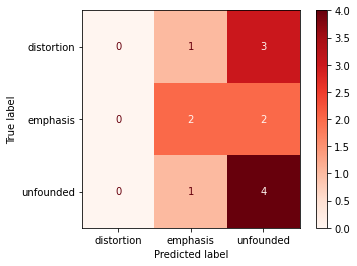

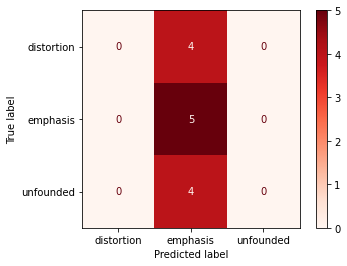

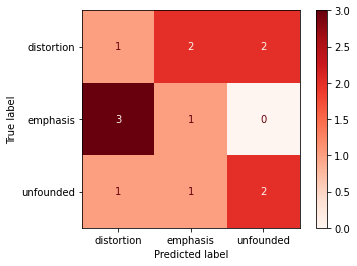

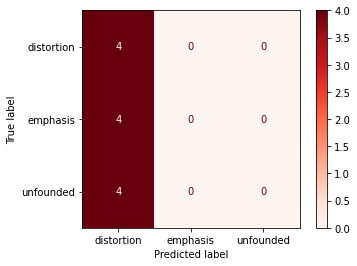

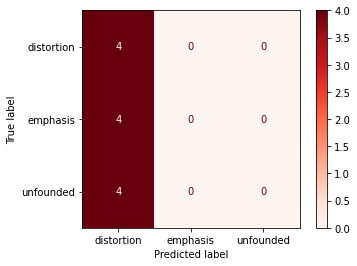

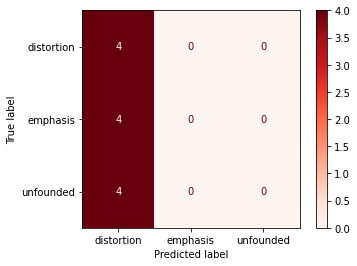

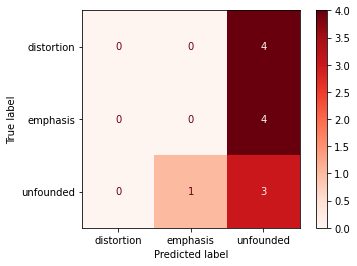

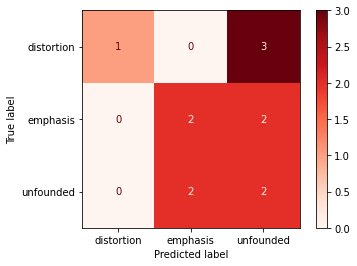

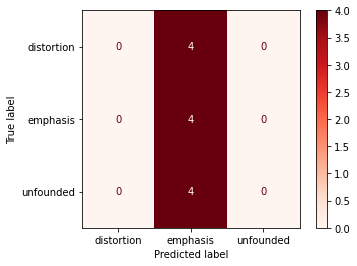

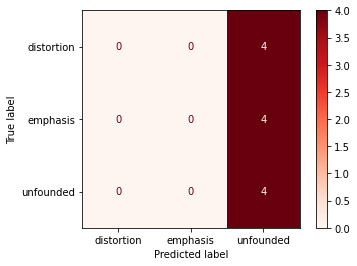

In [134]:
from sklearn.linear_model import SGDClassifier

# SGD Classifier

sgdClas = SGDClassifier()
parameters = {
                'penalty': ('l2', 'l1', 'elasticnet'),
                'alpha': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
                'max_iter' : [500, 1000, 10000],
                'tol': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
                'n_iter_no_change': [5, 10, 15, 20],
                'early_stopping': (True, False)
             }
sgdClassifier = GridSearchCV(sgdClas, parameters, n_jobs = -1, cv=10, scoring='f1_macro')

bestModel, bestAccuracyTest, bestAccuracyVal, bestParams = HyperParameterTuningWord2Vec(attentionData, sgdClassifier)

print("\n---- Word2Vec Results----\n")
# Word2Vec
accuracyArrayY, meanF1Score, meanAccuracyY = TenFoldValidation_Word2Vec(attentionData, bestModel)
print("Mean Accuracy: ", meanAccuracyY, " MeanF1Score: ",meanF1Score)

Fold  1  of tuning. F1Val:  0.46153846153846156  F1Kfold:  0.4022222222222222
Fold  2  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.2588888888888889
Fold  3  of tuning. F1Val:  0.38461538461538464  F1Kfold:  0.3288888888888889
Fold  4  of tuning. F1Val:  0.5833333333333334  F1Kfold:  0.2655555555555556
Fold  5  of tuning. F1Val:  0.4166666666666667  F1Kfold:  0.25222222222222224
Fold  6  of tuning. F1Val:  0.4166666666666667  F1Kfold:  0.27444444444444444
Fold  7  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.31333333333333335
Fold  8  of tuning. F1Val:  0.4166666666666667  F1Kfold:  0.31111111111111106
Fold  9  of tuning. F1Val:  0.4166666666666667  F1Kfold:  0.23222222222222225
Fold  10  of tuning. F1Val:  0.5833333333333334  F1Kfold:  0.2844444444444444

---- Tf-Idf Results----

Iteration: 1  Accuracy Score:  0.54
Iteration: 1  MacroF1 Score:  0.55
-------------------------------------
Iteration: 2  Accuracy Score:  0.23
Iteration: 2  MacroF1 Score:  0.21
----------------

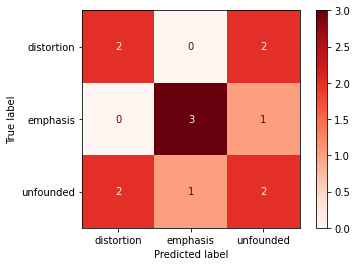

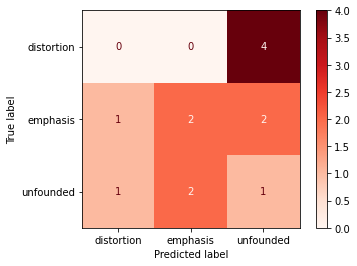

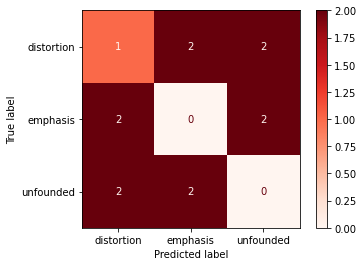

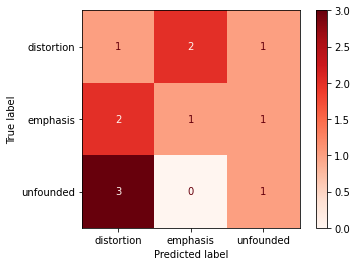

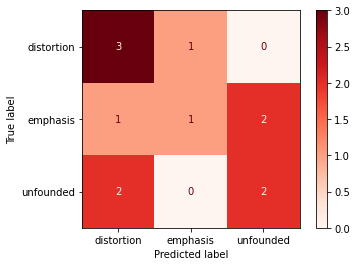

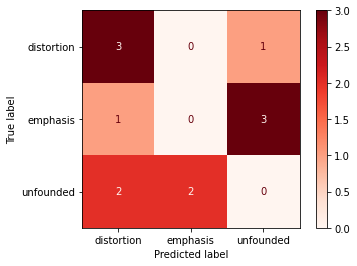

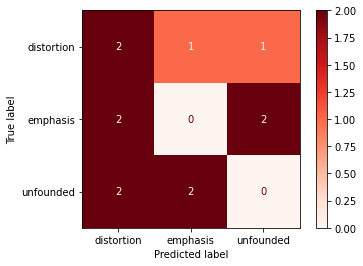

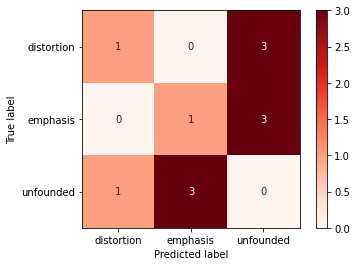

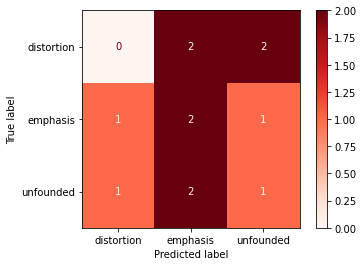

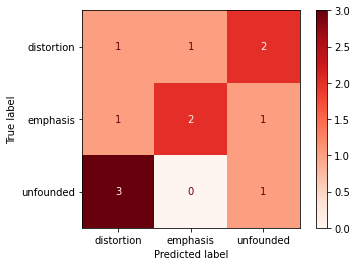

In [127]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression Evaluation

logRegClas = LogisticRegression(multi_class='ovr')
parameters = {
                'penalty': ('l2', 'none'),
                'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'),
                'max_iter': [100, 200, 500, 1000]
             }
logRegClassifier = GridSearchCV(logRegClas, parameters, n_jobs = -1, cv=10, scoring='accuracy')

bestModel, bestAccuracyTest, bestAccuracyVal, bestParams = HyperParameterTuningTfIdf(attentionData, logRegClassifier)

# Logistic Regression Tf-Idf
print("\n---- Tf-Idf Results----\n")
accuracyArrayX, meanF1Score, meanAccuracyX = TenFoldValidation_TfIdf(attentionData, bestModel)
print("Mean Accuracy: ", meanAccuracyX, " MeanF1Score: ",meanF1Score)

Fold  1  of tuning. F1Val:  0.46153846153846156  F1Kfold:  0.4022222222222222
Fold  2  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.2588888888888889
Fold  3  of tuning. F1Val:  0.38461538461538464  F1Kfold:  0.3288888888888889
Fold  4  of tuning. F1Val:  0.5833333333333334  F1Kfold:  0.2655555555555556
Fold  5  of tuning. F1Val:  0.4166666666666667  F1Kfold:  0.25222222222222224
Fold  6  of tuning. F1Val:  0.4166666666666667  F1Kfold:  0.27444444444444444
Fold  7  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.31333333333333335
Fold  8  of tuning. F1Val:  0.4166666666666667  F1Kfold:  0.31111111111111106
Fold  9  of tuning. F1Val:  0.4166666666666667  F1Kfold:  0.23222222222222225
Fold  10  of tuning. F1Val:  0.5833333333333334  F1Kfold:  0.2844444444444444

---- Word2Vec Results----

Iteration: 1  Accuracy Score:  0.38461538461538464
Iteration: 1  F1Macro  Score:  0.3212121212121212
-------------------------------------
Iteration: 2  Accuracy Score:  0.38461538461538464
Iter

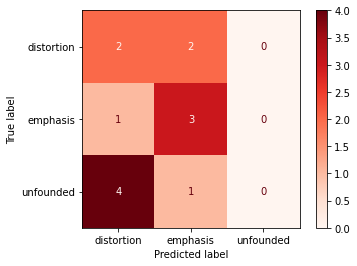

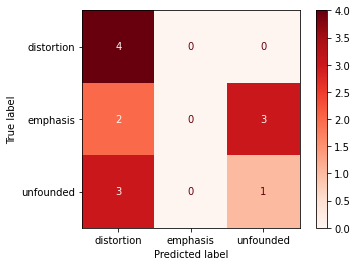

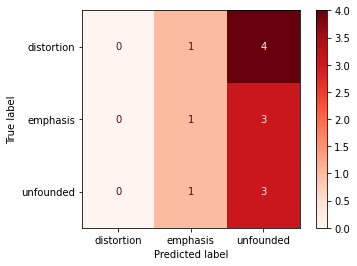

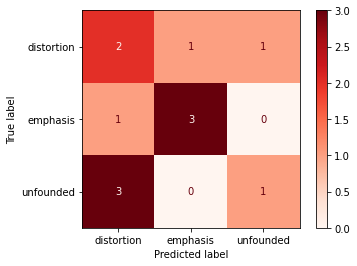

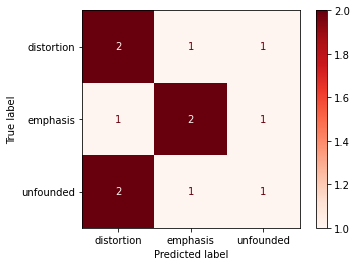

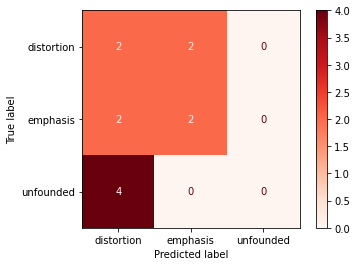

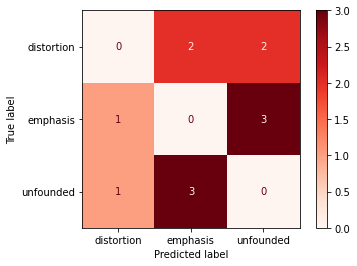

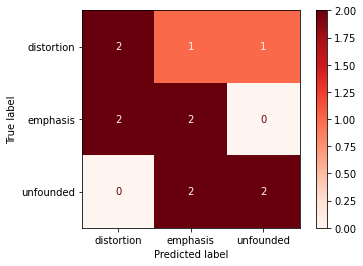

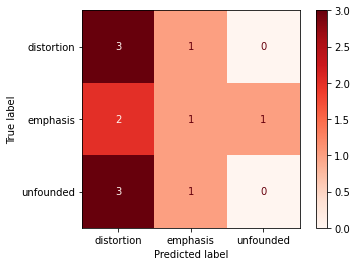

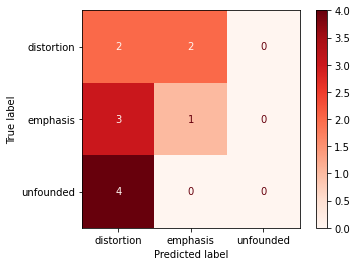

In [129]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression Evaluation

logRegClas = LogisticRegression(multi_class='ovr')
parameters = {
                'penalty': ('l2', 'none'),
                'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'),
                'max_iter': [100, 200, 500, 1000]
             }
logRegClassifier = GridSearchCV(logRegClas, parameters, n_jobs = -1, cv=10, scoring='accuracy')

bestModel, bestAccuracyTest, bestAccuracyVal, bestParams = HyperParameterTuningTfIdf(attentionData, logRegClassifier)

print("\n---- Word2Vec Results----\n")
# Word2Vec
accuracyArrayX, meanF1Score,meanAccuracyX = TenFoldValidation_Word2Vec(attentionData, bestModel)
print("Mean Accuracy: ", meanAccuracyY, " MeanF1Score",meanF1Score)

Fold  1  of tuning. F1Val:  0.46153846153846156  F1Kfold:  0.39333333333333337
Fold  2  of tuning. F1Val:  0.23076923076923078  F1Kfold:  0.29
Fold  3  of tuning. F1Val:  0.23076923076923078  F1Kfold:  0.35111111111111115
Fold  4  of tuning. F1Val:  0.4166666666666667  F1Kfold:  0.3344444444444445
Fold  5  of tuning. F1Val:  0.4166666666666667  F1Kfold:  0.2922222222222222
Fold  6  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.32333333333333336
Fold  7  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3533333333333334
Fold  8  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3411111111111111
Fold  9  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.27222222222222225
Fold  10  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3344444444444445

---- Tf-Idf Results----

Iteration: 1  Accuracy Score:  0.46
Iteration: 1  MacroF1 Score:  0.47
-------------------------------------
Iteration: 2  Accuracy Score:  0.31
Iteration: 2  MacroF1 Score:  0.28
------------------------------

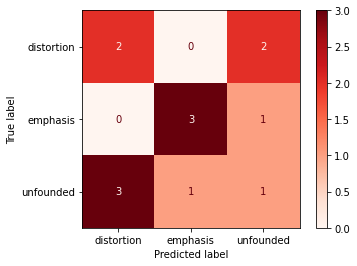

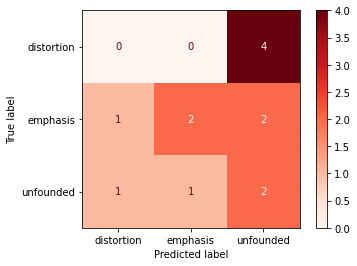

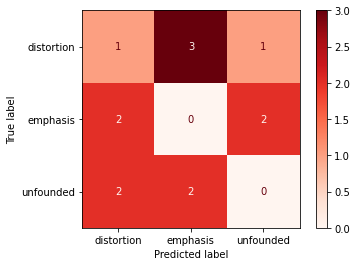

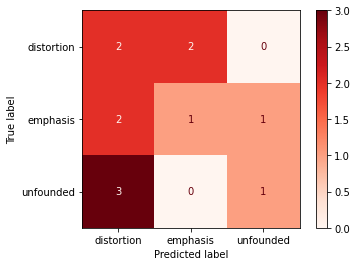

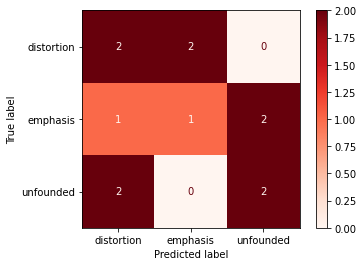

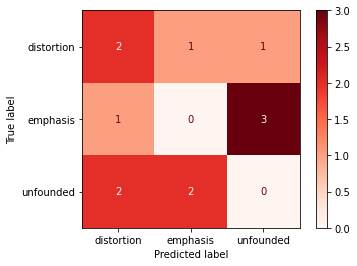

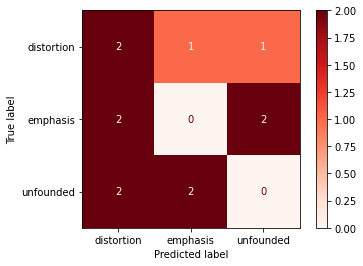

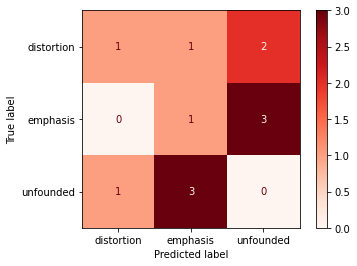

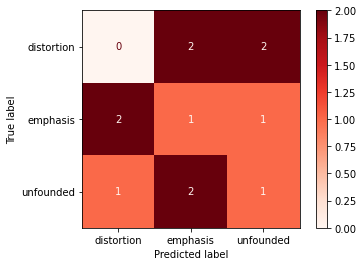

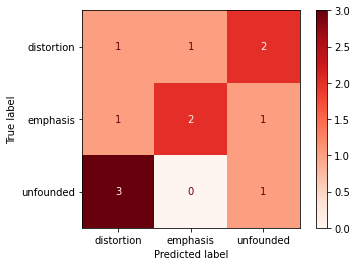

In [130]:
from sklearn.linear_model import RidgeClassifier

# Ridge Classifier Evaluation

ridgeClas = RidgeClassifier()
parameters = {
                'alpha': [0.05, 0.1, 0.5, 1, 2, 5, 10, 20],
                'tol' : [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
                'solver': ('auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs')
             }
ridgeClassifier = GridSearchCV(ridgeClas, parameters, n_jobs = -1, cv=10, scoring='accuracy')

bestModel, bestAccuracyTest, bestAccuracyVal, bestParams = HyperParameterTuningTfIdf(attentionData, ridgeClassifier)

# Logistic Regression Tf-Idf
print("\n---- Tf-Idf Results----\n")
accuracyArrayX, meanF1Score, meanAccuracyX = TenFoldValidation_TfIdf(attentionData, bestModel)
print("Mean Accuracy: ", meanAccuracyX, " MeanF1Score: ",meanF1Score)

Fold  1  of tuning. F1Val:  0.46153846153846156  F1Kfold:  0.4033333333333333
Fold  2  of tuning. F1Val:  0.23076923076923078  F1Kfold:  0.29000000000000004
Fold  3  of tuning. F1Val:  0.23076923076923078  F1Kfold:  0.35111111111111115
Fold  4  of tuning. F1Val:  0.4166666666666667  F1Kfold:  0.3344444444444445
Fold  5  of tuning. F1Val:  0.4166666666666667  F1Kfold:  0.2922222222222222
Fold  6  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.32333333333333336
Fold  7  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3533333333333334
Fold  8  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3411111111111111
Fold  9  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.27222222222222225
Fold  10  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.34444444444444444

---- Word2Vec Results----

Iteration: 1  Accuracy Score:  0.38461538461538464
Iteration: 1  F1Macro  Score:  0.3212121212121212
-------------------------------------
Iteration: 2  Accuracy Score:  0.38461538461538464
Ite

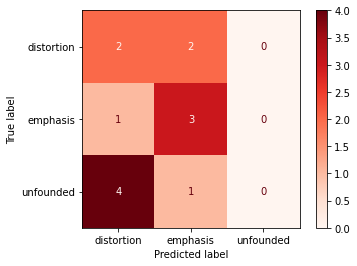

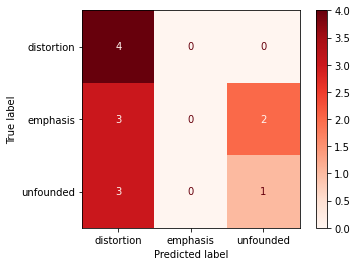

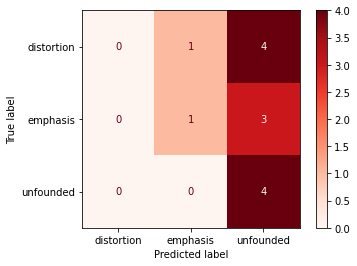

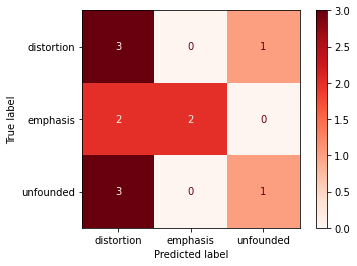

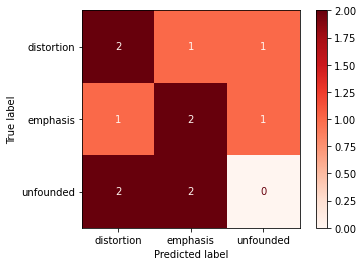

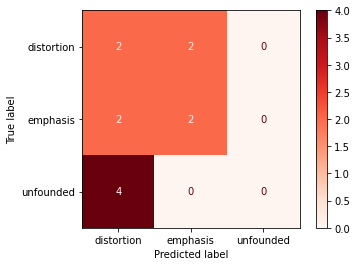

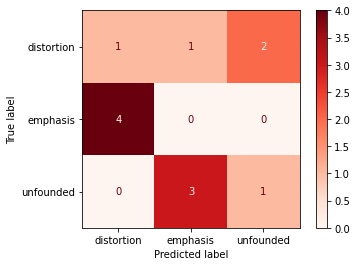

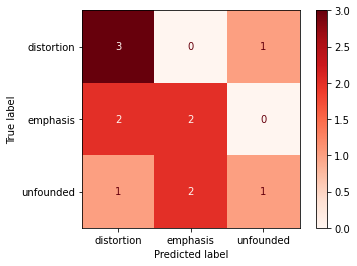

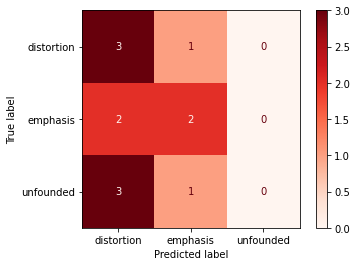

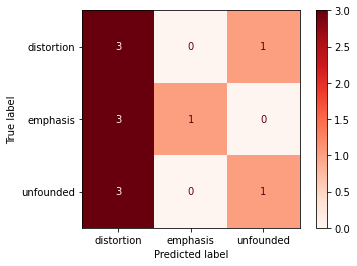

In [131]:
from sklearn.linear_model import RidgeClassifier

# Ridge Classifier Evaluation

ridgeClas = RidgeClassifier()
parameters = {
                'alpha': [0.05, 0.1, 0.5, 1, 2, 5, 10, 20],
                'tol' : [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
                'solver': ('auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs')
             }
ridgeClassifier = GridSearchCV(ridgeClas, parameters, n_jobs = -1, cv=10, scoring='accuracy')

bestModel, bestAccuracyTest, bestAccuracyVal, bestParams = HyperParameterTuningTfIdf(attentionData, ridgeClassifier)

print("\n---- Word2Vec Results----\n")
# Word2Vec
accuracyArrayX, meanF1Score, meanAccuracyX = TenFoldValidation_Word2Vec(attentionData, bestModel)
print("Mean Accuracy: ", meanAccuracyY, " MeanF1Score",meanF1Score)